# Проект "Аналитика данных компании Ge****o"

## Описание проекта: 
`Ge****o` – облачный сервис для автоматизации управления строительством и ремонтом.
Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.
Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.
 
## Цель проекта:

Проанализировать имеющиеся данные, составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, предложить решения по их минимизации. Определить ключевые признаки для компаний, наличие которых (или их появление) влияет на отмену (отсутствие оплаты) подписки.


In [1]:
from IPython.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

## Описание данных: 
 
Файл активностей (activities.csv). Сгруппирован по компаниям, отсортирован по компаниям, а в пределах каждой компании - по месяцам

|Столбец | Описание | Примечание|
|:--|:--|:--|
|Company_id |Идентификатор компании||
|Month|Отчетный месяц||
|Company-month-billing|Количество счетов, выставленных в приложении, компанией за месяц||
|Company-month-stocks|Месячное количество складов (аренда, заказы и т.д.), используемых компанией||
|Company-month-backups|Месячное количество бэкапов компании||
|Company-month-projects|Месячное количество проектов компании||
|Company-month-contractors|Месячное количество контрагентов компании||
|Company-month-resource_orders|Месячное количество заказов материалов компании||
 

Файл платежей (billing.csv)
|Столбец | Описание | Примечание|
|:--|:--|:--|
|Unnamed:0|Старый индекс||
|User_id|Идентификатор пользователя||
|Company_id|Идентификатор компании пользователя||
|Billing_tariff_id|Тарифный план| тарифы 1, 18, 22 - тестовые, бесплатные и пробные. Если такие есть - при анализе не должны использоваться. для остальных тарифов - основное различие - разное количество пользователей: тарифы 4, 7, 8, 11, 19 - группа “старт”, тарифы 2, 17 - группа “базовый”, тарифы 9, 20 - группа “бизнес”, тарифы 3, 10, 13, 21 - группа “Профи”, тариф 6 - “архивный”, в настоящее время не используется|
|Payed_until| Дата, до которой подписка компании действует||
|Is_payed| Статус оплаты||
|Created_at|Дата создания||
|Updated_at|Дата обновления||
|Billing_tariff_price_id|id стоимости тарифа|в разное время или для разных клиентов  один и тот же тариф может стоить по-разному |
|Comment|Комментарии||
|Pay_date|Дата платежа||
 

 
Файл компаний (companies.csv)
|Столбец | Описание | Примечание|
|:--|:--|:--|
|Id| id компании||
|Working_direction| сфера деятельности||
|Employer_count_interval| id количества сотрудников| По возрастающей id от 1 до 8, количество сотрудников - (1-4, 5-10, 11-20, 21-30, 31-50, 51-100, 101-200, >201)|
|Created_at| дата создания компании в системе||
|Updated_at| дата обновления информации о компании||
|Billing_tariff_id|id тарифа| см. выше|
|Billing_is_over| истекла ли оплата||
 


Файл сотрудников (people.csv)
|Столбец | Описание | Примечание|
|:--|:--|:--|
|Id|индекс||
|Company_id| id компании||
|User_id| id пользователя||
|Role_id| id роли (должности)||
|Created_at| дата создания пользователя||
|Updated_at| дата обновления информации о пользователе||
|Is_deleted| удален ли пользователь||
|Deleted_at| дата удаления||

## План работы:

1. Загрузка данных
2. Предобработка данных
3. Провести исследовательский анализ данных
4. Выводы



## 1. Загрузка необходимых библиотек и данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import requests
from urllib.parse import urlencode
import io
from scipy import stats as st
import stat as st
import math 

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
pd.options.display.precision = 2
pd.options.display.float_format ='{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams["figure.figsize"] = 10, 6
sns.set_style("whitegrid", {'axes.grid' : True})



In [3]:
colors = ['#3a66bc', '#7f899c', '#ffde00', '#22ab4d', '#88bd98']
palette = sns.color_palette(colors)
palette

[(0.22745098039215686, 0.4, 0.7372549019607844),
 (0.4980392156862745, 0.5372549019607843, 0.611764705882353),
 (1.0, 0.8705882352941177, 0.0),
 (0.13333333333333333, 0.6705882352941176, 0.30196078431372547),
 (0.5333333333333333, 0.7411764705882353, 0.596078431372549)]

In [4]:
colors1 = ['#3a66bc','#FF9B42','#22ab4d','#ffde00','#DE663E','#6895D2','#7f899c']
palette = sns.color_palette(colors1)
palette

[(0.22745098039215686, 0.4, 0.7372549019607844),
 (1.0, 0.6078431372549019, 0.25882352941176473),
 (0.13333333333333333, 0.6705882352941176, 0.30196078431372547),
 (1.0, 0.8705882352941177, 0.0),
 (0.8705882352941177, 0.4, 0.24313725490196078),
 (0.40784313725490196, 0.5843137254901961, 0.8235294117647058),
 (0.4980392156862745, 0.5372549019607843, 0.611764705882353)]

In [5]:
import requests
from urllib.parse import urlencode
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

links = ['https://disk.yandex.ru/d/lhykHBbssqnNpQ', 'https://disk.yandex.ru/d/m5l43tRmmv4F7w', 'https://disk.yandex.ru/d/RJQP3bcwpsYlmg', 'https://disk.yandex.ru/d/3PGE_XAwMeoN5w']
names = ['activities', 'billing', 'companies', 'people']

for name, link in zip(names, links):

    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    download_response = requests.get(download_url)
    vars()[name] = pd.read_csv(io.BytesIO(download_response.content))

In [6]:
activities.head(2)

,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,0,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00
1,1,1,2019-12-01 00:00:00+00:00,1.00,0.00,0.00,2.00,1.00,0.00


In [7]:
billing.head(2)

,Unnamed: 0.1,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
0,4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.00,NaN,NaN
1,6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.00,NaN,1608626181.00


In [8]:
companies.head(2)

,Unnamed: 0,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,19,514,-,1.00,1571316635,1670298314,4.00,True
1,57,383,Строительство,2.00,1564142565,1676550050,7.00,False


In [9]:
people.head(2)

,Unnamed: 0,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,2,6601,495,NaN,7133,1570535962,1570535962,True,1594066768.00
1,6,7025,1,NaN,1,1594120484,1594120484,True,1594120488.00


Данные загружены корректно

## 2. Предобработка данных

### 2.1 Файл активностей (activities.csv)

In [10]:
activities.head()

,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,0,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00
1,1,1,2019-12-01 00:00:00+00:00,1.00,0.00,0.00,2.00,1.00,0.00
2,2,1,2020-04-01 00:00:00+00:00,4.00,1.00,0.00,1.00,6.00,0.00
3,3,1,2020-07-01 00:00:00+00:00,1.00,7.00,3.00,5.00,0.00,0.00
4,4,21,2020-01-01 00:00:00+00:00,3.00,0.00,0.00,1.00,0.00,0.00


In [11]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     6316 non-null   int64  
 1   company_id                     6316 non-null   int64  
 2   month                          6316 non-null   object 
 3   company-month-billing          6316 non-null   float64
 4   company-month-stocks           6316 non-null   float64
 5   company-month-backups          6316 non-null   float64
 6   company-month-projects         6316 non-null   float64
 7   company-month-contractors      6316 non-null   float64
 8   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 444.2+ KB


Столбец `Unnamed: 0` требуется удалить, столбец с датой преобразовать, столбцы с информацией по проектам привести к целочисленному виду. Пропусков в таблице нет.

In [12]:
activities['month'] = pd.to_datetime(activities['month']).dt.strftime('%Y-%m')

In [13]:
activities=activities.astype({'company-month-billing':'int64', 'company-month-stocks':'int64','company-month-backups':'int64','company-month-projects':'int64',\
                              'company-month-contractors':'int64','company-month-resource_orders':'int64'}, errors='ignore')

In [14]:
activities.drop('Unnamed: 0', axis= 1 , inplace= True ) 

In [15]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   company_id                     6316 non-null   int64 
 1   month                          6316 non-null   object
 2   company-month-billing          6316 non-null   int64 
 3   company-month-stocks           6316 non-null   int64 
 4   company-month-backups          6316 non-null   int64 
 5   company-month-projects         6316 non-null   int64 
 6   company-month-contractors      6316 non-null   int64 
 7   company-month-resource_orders  6316 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 394.9+ KB


In [16]:
# явные дубликаты
activities.duplicated().sum()


0

In [17]:
activities['month'].min(), activities['month'].max()

('2019-01', '2024-03')

Данные предоставлены с января 2019 по март 2024. Скорее всего последний месяц не содержит полных данных, т.к. дата начала проекта - март 2024 года.

Т.к. в данной таблице данные отображаются для всех компаний, то нет смысла смотреть статистики по всему массиву данных. Выбросы и прочее интереснее посмотреть по каждой компании. 
Сначала посмотрим, сколько всего уникальных компаний представлено в данных.

In [18]:
activities['company_id'].nunique()

716

In [19]:
# сделаем новые процентили для поиска аномалий
new_percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99] 
activities.loc[:, activities.columns != 'company_id'].describe(percentiles = new_percentiles).T 

,count,mean,std,min,1%,5%,25%,50%,75%,90%,95%,99%,max
company-month-billing,6316.00,0.38,0.80,0.00,0.00,0.00,0.00,0.00,1.00,1.00,2.00,3.00,16.00
company-month-stocks,6316.00,7.41,13.11,0.00,0.00,0.00,1.00,3.00,8.00,20.00,33.00,66.00,166.00
company-month-backups,6316.00,1.18,3.14,0.00,0.00,0.00,0.00,0.00,0.00,4.00,10.00,12.85,22.00
company-month-projects,6316.00,7.26,13.90,0.00,0.00,0.00,1.00,2.00,7.00,19.00,32.00,66.00,221.00
company-month-contractors,6316.00,7.91,27.97,0.00,0.00,0.00,0.00,2.00,7.00,18.00,31.00,82.00,1014.00
company-month-resource_orders,6316.00,10.35,40.57,0.00,0.00,0.00,0.00,0.00,4.00,21.00,55.00,177.85,1182.00


Отберем компании (id), в действиях которых зафиксированы значения, похожие на выбросы. их следует рассмотреть в дальнейшем, отдельно. Возможно, это просто самые активные пользователи. Но если у этих компаний, например, бесплатный тариф, то можно считать их действия шумом и не учитывать в статистике.

In [20]:
columns = ['company-month-billing', 'company-month-stocks',
       'company-month-backups', 'company-month-projects',
       'company-month-contractors', 'company-month-resource_orders']

In [21]:
id_company_max = []
for col in columns:
    df = activities[activities[col] >= activities[col].quantile(0.99)]
    id_company_max.extend(df['company_id'].values)

In [22]:
id_company_max = list(set(id_company_max))

In [23]:
len(id_company_max)

205

Количество таких фирм - 205. Возможно среди них удастся вычислить наиболее активных подписчиков.

### 2.2 Файл платежей (billing.csv)

In [24]:
billing.head()

,Unnamed: 0.1,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
0,4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.00,NaN,NaN
1,6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.00,NaN,1608626181.00
2,16,16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.00,NaN,NaN
3,18,18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.00,NaN,NaN
4,24,24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.00,NaN,1609200000.00


In [25]:
billing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0.1             3480 non-null   int64  
 1   Unnamed: 0               3480 non-null   int64  
 2   id                       3480 non-null   int64  
 3   user_id                  3480 non-null   int64  
 4   company_id               3480 non-null   int64  
 5   billing_tariff_id        3480 non-null   int64  
 6   payed_until              3480 non-null   int64  
 7   is_payed                 3480 non-null   bool   
 8   created_at               3480 non-null   int64  
 9   updated_at               3480 non-null   int64  
 10  billing_tariff_price_id  3480 non-null   float64
 11  comment                  745 non-null    object 
 12  pay_date                 1108 non-null   float64
dtypes: bool(1), float64(2), int64(9), object(1)
memory usage: 329.8+ KB


- Столбцы индексов  `Unnamed: 0.1` и `Unnamed: 0 ` дублируются, и не несут нужной информации, их можно удалить. Стоит задать вопрос заказчику, почему индекс выгружался не по порядку?
- Пропуски есть в столбцах с комментариями и с датой платежа.
- Даты (`столбцы payed_until, created_at, updated_at, pay_date`) следует привести к нужному типу
- `Billing_tariff_price_id` скорее всего целочисленный, проверить и по необходимости изменить тип

In [26]:
billing['payed_until'] = pd.to_datetime(billing.payed_until, unit='s')
billing['created_at'] = pd.to_datetime(billing.created_at, unit='s')
billing['updated_at'] = pd.to_datetime(billing.updated_at, unit='s')
billing['pay_date'] = pd.to_datetime(billing.pay_date, unit='s')


In [27]:
billing=billing.astype({'billing_tariff_price_id':'int64'}, errors='ignore')

In [28]:
billing.drop(['Unnamed: 0.1','Unnamed: 0'], axis= 1 , inplace= True ) 

In [29]:
# явные дубликаты
billing.duplicated().sum()

0

Явных дубликатов нет, но в данных много временных полей, где время указано с точностью до секунд. Создадим дополнительные поля, учитывающие только часы и посмотрим, есть ли дубликаты там. Если дубликаты найдутся, возможно следует посмотреть и минуты и искать дубликаты там. Если в часовых промежутках дубликатов нет, то вспомогательные столбцы можно удалить.

In [30]:
billing['payed_until_H'] = billing['payed_until'].dt.strftime('%Y-%m-%d %H')
billing.insert(5,'payed_until_H', billing.pop('payed_until_H'))

In [31]:
billing['created_at_H'] = billing['created_at'].dt.strftime('%Y-%m-%d %H')
billing.insert(8,'created_at_H', billing.pop('created_at_H'))

In [32]:
billing['updated_at_H'] = billing['updated_at'].dt.strftime('%Y-%m-%d %H')
billing.insert(10,'updated_at_H', billing.pop('updated_at_H'))

In [33]:
billing['pay_date_H'] = billing['pay_date'].dt.strftime('%Y-%m-%d %H')

In [34]:
df = billing[['id', 'user_id', 'company_id', 'billing_tariff_id', 'payed_until_H', 'is_payed',  'created_at_H', 'updated_at_H', 'billing_tariff_price_id', 'comment', 'pay_date_H']]

In [35]:
df.duplicated().sum()

0

Дубликатов нет. Тк данные содержат историю операций, то нет смысла обобщать и искать дубликаты в днях или месяцах. Они возможны и не противоречат данным. Делая проверку по часам, можно быть уверенным, что ошибок выгрузки, которые плодят дубикаты, нет.

Даты создания действий ограничиваются периодом:

In [36]:
billing['created_at_H'].min(), billing['created_at_H'].max()

('2019-07-23 09', '2024-03-13 10')

Следовательно с начала даты активностей (январь 2019)  первая  информация  в данных по платежам появилась  только 23/07/2019. Те за первые пол-года нет иформации по платежам. Возможно компания давала бесплатный ознакомительный период и данные в таблицу billing не фиксировались.

В информации по тарифам указано, что тарифы 1, 18, 22 - тестовые, бесплатные и пробные. Если такие есть - при анализе не должны использоваться. Проверим, есть ли такие тарифы в данных.

In [37]:
billing['billing_tariff_id'].isin([1,18,22]).sum()

0

тариф 6 - “архивный”, в настоящее время не используется

In [38]:
billing['billing_tariff_id'].isin([6]).sum()

17

С этим тарифом 17 записей. Возможно их следует исключить из анаиза. Посмотрим на них подробнее.

In [39]:
billing[billing['billing_tariff_id'].isin([6])]

,id,user_id,company_id,billing_tariff_id,payed_until,payed_until_H,is_payed,created_at,created_at_H,updated_at,updated_at_H,billing_tariff_price_id,comment,pay_date,pay_date_H
83,3046,567,512,6,2021-06-21 14:55:39,2021-06-21 14,False,2020-12-21 14:55:39,2020-12-21 14,2020-12-21 14:55:39,2020-12-21 14,17,NaN,NaT,NaN
113,4481,1683,1451,6,2022-06-18 00:00:00,2022-06-18 00,True,2021-06-16 16:30:49,2021-06-16 16,2021-06-22 09:01:10,2021-06-22 09,18,NaN,2021-06-16 00:00:00,2021-06-16 00
188,4576,4458,3640,6,2022-07-10 00:00:00,2022-07-10 00,True,2021-06-25 19:15:11,2021-06-25 19,2021-06-29 10:10:11,2021-06-29 10,18,NaN,2021-06-25 00:00:00,2021-06-25 00
219,5323,3436,2906,6,2022-09-01 00:00:00,2022-09-01 00,False,2021-09-01 11:43:54,2021-09-01 11,2021-09-01 11:44:18,2021-09-01 11,18,NaN,2021-09-02 00:00:00,2021-09-02 00
354,3725,3436,2906,6,2022-04-01 00:00:00,2022-04-01 00,False,2021-04-01 12:31:32,2021-04-01 12,2021-04-01 12:31:34,2021-04-01 12,18,NaN,NaT,NaN
364,3726,3436,2906,6,2022-04-01 00:00:00,2022-04-01 00,False,2021-04-01 12:31:55,2021-04-01 12,2021-04-01 12:31:58,2021-04-01 12,18,NaN,NaT,NaN
387,3727,3436,2906,6,2022-10-01 00:00:00,2022-10-01 00,False,2021-04-01 12:32:15,2021-04-01 12,2021-04-01 12:32:16,2021-04-01 12,27,NaN,NaT,NaN
665,4231,3903,3244,6,2023-07-05 00:00:00,2023-07-05 00,True,2021-05-24 12:39:30,2021-05-24 12,2021-05-31 13:27:00,2021-05-31 13,19,NaN,2021-06-05 00:00:00,2021-06-05 00
688,4313,2834,2459,6,2023-07-02 00:00:00,2023-07-02 00,True,2021-06-01 06:53:28,2021-06-01 06,2021-06-01 07:10:06,2021-06-01 07,18,24 мес + 30дней,2021-06-01 00:00:00,2021-06-01 00
875,1014,461,419,6,2020-10-01 00:00:00,2020-10-01 00,True,2020-03-30 14:24:24,2020-03-30 14,2020-03-31 09:46:11,2020-03-31 09,17,"оплатил 31,03",NaT,NaN


Среди этих записей были и оплаченные и не оплаченные тарифы, но у всех закончилось действие подписки в 2023 году. Кроме 1 записи, где окончание 07/24. Судя по остальным данным это была оплаченная подписка на 2 года. На этом этапе не имеет смысл удалять эти данные. Оставим как есть.

In [40]:
billing['company_id'].nunique()

1841

Количество компаний, о которых есть информация в таблице платежей - 1841, а в таблице активностей - 716. Следует уточнить у заказчика, почему данные так различаются?
Возможно, в таблицу активностей заносили не всех? или выгрузка не полная?

In [41]:
activities[(activities['month']>='2023-01')&(activities['month']<='2023-12')]['company_id'].nunique()

351

In [42]:
billing[pd.to_datetime(billing['created_at']).dt.strftime('%Y')=='2023']['company_id'].nunique()

319

Данные согласованы лучше. Посмотрим так же на 2022 и 2024 годы.

2022 год:

In [43]:
activities[(activities['month']>='2022-01')&(activities['month']<='2022-12')]['company_id'].nunique()

361

In [44]:
billing[pd.to_datetime(billing['created_at']).dt.strftime('%Y')=='2022']['company_id'].nunique()

719

2024 год: 

In [45]:
activities[(activities['month']>='2024-01')&(activities['month']<='2024-12')]['company_id'].nunique()

177

In [46]:
billing[pd.to_datetime(billing['created_at']).dt.strftime('%Y')=='2024']['company_id'].nunique()

76

- В 2022 год уникальных компаний в платежах намного больше, чем в активности. Это не логично и наводит на мысль, что либо данные собирались плохо либо выгрузили не все. 
- в 2023 году кол-во компаний примерно похоже, и в платежах меньше, чем в активностях. что более логично.
- в 2024 году в платежах компаний меньше, чем в активностях, что тоже логично, ведь многие покупали подписку на 1-2 года сразу, поэтому информации по платежам у фирмы может не быть, а по действиям есть.

  **Т.к. задачей проекта является определение признаков, влияющих на отток сегодня, то нет смысла анализировать исторические данные. Тем более, что есть некоторые странности в них.
  В дальнейшем анализе будем использовать данные за 2023-2024 годы.**  

In [47]:
billing.drop(['payed_until_H', 'created_at_H', 'updated_at_H', 'pay_date_H'], axis= 1 , inplace= True ) 

Создадим столбец категорий, определяющий тариф по условию: тарифы 4, 7, 8, 11, 19 - группа “старт”, тарифы 2, 17 - группа “базовый”, тарифы 9, 20 - группа “бизнес”, тарифы 3, 10, 13, 21 - группа “Профи”, тариф 6 - “архивный”, в настоящее время не используется

In [48]:
start = [4, 7, 8, 11, 19] 
baza = [ 2, 17 ]
biz = [9, 20]
proff = [3, 10, 13, 21]
arxiv = [6]
billing['tariff_cat'] = np.where (billing['billing_tariff_id'].isin(start), 'старт', \
                                   np.where (billing['billing_tariff_id'].isin(baza), 'база', \
                                   np.where (billing['billing_tariff_id'].isin(biz), 'бизнес',\
                                   np.where (billing['billing_tariff_id'].isin(proff), 'профи',\
                                              np.where (billing['billing_tariff_id'].isin(arxiv), 'архив', 'н/д' )                                               
                                                                              ))))
billing.insert(4,'tariff_cat',billing.pop('tariff_cat'))


In [49]:
billing

,id,user_id,company_id,billing_tariff_id,tariff_cat,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
0,3050,567,512,3,профи,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT
1,3051,2861,2474,7,старт,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21
2,3059,1902,1645,2,база,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6,NaN,NaT
3,3065,2352,2035,7,старт,2022-01-29 23:59:59,False,2020-12-25 07:59:35,2020-12-25 07:59:35,23,NaN,NaT
4,3062,1074,926,3,профи,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9,NaN,2020-12-29 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3475,14362,14513,10848,2,база,2025-03-18 23:59:59,False,2024-03-12 15:53:34,2024-03-12 15:53:34,8,NaN,NaT
3476,14364,4980,4004,17,база,2025-03-12 00:00:00,False,2024-03-12 17:15:17,2024-03-12 17:15:29,5,NaN,NaT
3477,14365,13378,9841,7,старт,2025-03-13 00:00:00,False,2024-03-12 17:52:29,2024-03-12 17:53:29,23,NaN,2024-03-15 00:00:00
3478,13441,10388,7745,2,база,2025-04-29 00:00:00,True,2024-02-16 09:03:44,2024-03-13 10:21:58,8,"13,03,24 - добавили 3 месяца к подписке из-за слетевших каталогов Оеруа мерлен (у них были на их основе справочник операций сформирован)",2024-02-16 00:00:00


### 2.3 Файл компаний (companies.csv)

In [50]:
companies.head()

,Unnamed: 0,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,19,514,-,1.00,1571316635,1670298314,4.00,True
1,57,383,Строительство,2.00,1564142565,1676550050,7.00,False
2,69,495,-,1.00,1570535695,1598281714,2.00,False
3,75,724,-,1.00,1579514393,1670298294,4.00,True
4,99,471,-,1.00,1569328017,1670298360,7.00,True


In [51]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               723 non-null    int64  
 1   id                       723 non-null    int64  
 2   working_direction        720 non-null    object 
 3   employer_count_interval  723 non-null    float64
 4   created_at               723 non-null    int64  
 5   updated_at               723 non-null    int64  
 6   billing_tariff_id        716 non-null    float64
 7   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(1)
memory usage: 40.4+ KB


Столбец `Unnamed: 0` следует удалить, столбец `id` переименовать в `company_id` , столбцы `created_at` и  `updated_at` перевести в тип дата,  
столбцы `billing_tariff_id` - тип тарифа  и `employer_count_interval` - категория кол-ва сотрудников,  требуется  перевести в целое чило, столбец `working_direction` имеет много неявных пропусков, предобразовать это.


In [52]:
companies.drop('Unnamed: 0', axis= 1 , inplace= True ) 

In [53]:
companies.rename(columns = {'id':'company_id'}, inplace = True )

In [54]:
companies['created_at'] = pd.to_datetime(companies.created_at, unit='s')
companies['updated_at'] = pd.to_datetime(companies.updated_at, unit='s')

In [55]:
companies=companies.astype({'billing_tariff_id':'int64', 'employer_count_interval':'int64'}, errors='ignore')

In [56]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   company_id               723 non-null    int64         
 1   working_direction        720 non-null    object        
 2   employer_count_interval  723 non-null    int64         
 3   created_at               723 non-null    datetime64[ns]
 4   updated_at               723 non-null    datetime64[ns]
 5   billing_tariff_id        716 non-null    float64       
 6   billing_is_over          723 non-null    bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 34.7+ KB


 В столбце с тарифами есть пропуски, поэтому тип данных не поменялся. Остальные правки корректны.
 Можно привести к типу Int64, он корректно отображает пропуски


In [57]:
companies=companies.astype({'billing_tariff_id':'Int64'}, errors='ignore')

In [58]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   company_id               723 non-null    int64         
 1   working_direction        720 non-null    object        
 2   employer_count_interval  723 non-null    int64         
 3   created_at               723 non-null    datetime64[ns]
 4   updated_at               723 non-null    datetime64[ns]
 5   billing_tariff_id        716 non-null    Int64         
 6   billing_is_over          723 non-null    bool          
dtypes: Int64(1), bool(1), datetime64[ns](2), int64(2), object(1)
memory usage: 35.4+ KB


In [59]:
companies['working_direction'].unique()

array(['-', 'Строительство', 'Генеральный подрядчик',
       'Строительная компания', 'Ремонт помещений', 'строительство ',
       'ремонт и отделка', 'СТРОИТЕЛЬСТВО', 'строительство',
       'Строительство домов', 'телемаркетинг', 'ремонт',
       'Ремонт и отделка помещений', '-Малоэтажное строительство',
       'Отделка ', 'Отделка',
       'Проектирование и строительство ресторанов ',
       'строительство  и отделка', 'ремонты', 'Электромонтажные работы',
       'строительная компания (тест)', 'Строительство и ремонт',
       'Демонтажные работы', 'Строительство рыбоводных ферм',
       'Строительно-монтажные работы', 'Строительство каркасных домов',
       'Дизайн интерьеров', 'Ремонтные работы',
       'Малоэтажное строительство ', nan, 'Ремонтно-строительная ',
       'Ремонт под ключ', 'Электромонтаж',
       'Проектирование,  Производство и Строительство',
       'Строительство коттеджей', 'Строительство загородных домов',
       'Малоэтажное строительство', 'Электроэнергетик

In [60]:
companies['working_direction'].nunique()

170

Поле содержит множество повторов, данные набирались вручную, поэтому регистр влияет на значение. Так же есть значок ` - `, который отражает пропуск значения.
Упростим данные для дальнейшего анализа.

In [61]:
companies['working_direction'] = companies['working_direction'].str.replace('.', '')
companies['working_direction']= companies['working_direction'].astype(str).str.strip()
companies['working_direction'] = companies['working_direction'].str.replace('  ', '')
companies['working_direction'] = companies['working_direction'].str.strip('-')

In [62]:
companies['working_direction'] = companies['working_direction'].apply(lambda x: x.lower())
companies = companies.replace('nan', np.nan)

In [63]:
companies['working_direction'].unique()

array(['', 'строительство', 'генеральный подрядчик',
       'строительная компания', 'ремонт помещений', 'ремонт и отделка',
       'строительство домов', 'телемаркетинг', 'ремонт',
       'ремонт и отделка помещений', 'малоэтажное строительство',
       'отделка', 'проектирование и строительство ресторанов',
       'строительствои отделка', 'ремонты', 'электромонтажные работы',
       'строительная компания (тест)', 'строительство и ремонт',
       'демонтажные работы', 'строительство рыбоводных ферм',
       'строительно-монтажные работы', 'строительство каркасных домов',
       'дизайн интерьеров', 'ремонтные работы', nan,
       'ремонтно-строительная', 'ремонт под ключ', 'электромонтаж',
       'проектирование,производство и строительство',
       'строительство коттеджей', 'строительство загородных домов',
       'электроэнергетика', 'изготовление заборов', 'ремонт квартир',
       'девелопмент', 'строительство спортивных и детски площадок',
       'строительная', 'частное домост

In [64]:
companies['working_direction'].nunique()

144

Создадим категориальный столбец, который будет отражать, отнносится ли компания к строительству, ремонту или к другой категории. Конкретных записей не так много, много пропусков, возможно это не обязательный к заполнению пункт и не все компании его заполняли.

In [65]:
keep = ['дизайн']
companies['working_direction_cat'] = np.where(companies['working_direction'].str.contains('|'.join(keep)), 'дизайн', 'другое')

In [66]:
keep = ['производство', 'изготовление' ]
companies['working_direction_cat'] = np.where(companies['working_direction'].str.contains('|'.join(keep)), 'производство', companies['working_direction_cat'])

In [67]:
keep = ['строитель']
companies['working_direction_cat'] = np.where(companies['working_direction'].str.contains('|'.join(keep)), 'строительство', companies['working_direction_cat'])

In [68]:
keep = ['ремонт']
companies['working_direction_cat'] = np.where(companies['working_direction'].str.contains('|'.join(keep)), 'ремонт', companies['working_direction_cat'])

In [69]:
keep = ['ремонт', 'строитель']
companies['working_direction_cat'] = np.where(companies['working_direction'].str.contains('ремонт') &  companies['working_direction'].str.contains('строитель'), 'строительство и ремонт',companies['working_direction_cat'] )

In [70]:
companies['working_direction_cat'] = np.where(companies['working_direction'].str.len() >=1,  companies['working_direction_cat'], 'н/д')

In [71]:
companies.insert(2,'working_direction_cat', companies.pop('working_direction_cat'))

In [72]:
companies.head()

,company_id,working_direction,working_direction_cat,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,,н/д,1,2019-10-17 12:50:35,2022-12-06 03:45:14,4,True
1,383,строительство,строительство,2,2019-07-26 12:02:45,2023-02-16 12:20:50,7,False
2,495,,н/д,1,2019-10-08 11:54:55,2020-08-24 15:08:34,2,False
3,724,,н/д,1,2020-01-20 09:59:53,2022-12-06 03:44:54,4,True
4,471,,н/д,1,2019-09-24 12:26:57,2022-12-06 03:46:00,7,True


In [73]:
companies['created_at'].min(), companies['created_at'].max()

(Timestamp('2019-01-23 14:00:51'), Timestamp('2024-02-07 12:56:09'))

In [74]:
companies['company_id'].nunique()

723

### 2.4 Файл сотрудников (people.csv)

In [75]:
people.head()

,Unnamed: 0,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,2,6601,495,NaN,7133,1570535962,1570535962,True,1594066768.00
1,6,7025,1,NaN,1,1594120484,1594120484,True,1594120488.00
2,7,7165,1255,1734.00,18085,1595438102,1595439391,True,1633960082.00
3,10,7130,1470,1703.00,1,1595234824,1595234824,False,NaN
4,17,7163,1492,1731.00,1,1595429211,1598540644,True,1620195318.00


In [76]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5095 non-null   int64  
 1   id          5095 non-null   int64  
 2   company_id  5095 non-null   int64  
 3   user_id     3813 non-null   float64
 4   role_id     5095 non-null   int64  
 5   created_at  5095 non-null   int64  
 6   updated_at  5095 non-null   int64  
 7   is_deleted  5095 non-null   bool   
 8   deleted_at  2180 non-null   float64
dtypes: bool(1), float64(2), int64(6)
memory usage: 323.5 KB


- столбец `Unnamed: 0' удалить, столбцы с датами перевести в нужный тип. 
- столбец `user_id` содержит пропуски и требует перевода в целочисленный тип
- столбец `deleted_at` содержит пропуски и требует перевода в в нужный тип
- столбец `id`  содержит индекс, значение которого не указано в информации о данных, возможно удалить.

In [77]:
people.drop('Unnamed: 0', axis= 1 , inplace= True ) 

In [78]:
people['created_at'] = pd.to_datetime(people.created_at, unit='s')
people['updated_at'] = pd.to_datetime(people.updated_at, unit='s')
people['deleted_at'] = pd.to_datetime(people.deleted_at, unit='s')

In [79]:
people=people.astype({'user_id':'Int64'}, errors='ignore')

In [80]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5095 non-null   int64         
 1   company_id  5095 non-null   int64         
 2   user_id     3813 non-null   Int64         
 3   role_id     5095 non-null   int64         
 4   created_at  5095 non-null   datetime64[ns]
 5   updated_at  5095 non-null   datetime64[ns]
 6   is_deleted  5095 non-null   bool          
 7   deleted_at  2180 non-null   datetime64[ns]
dtypes: Int64(1), bool(1), datetime64[ns](3), int64(3)
memory usage: 288.7 KB


In [81]:
people['company_id'].nunique()

712

In [82]:
people.groupby('company_id')['user_id'].nunique().sort_values(ascending=False)

company_id
3623    42
3518    40
6806    38
3705    36
3524    32
        ..
4868     1
2670     1
4743     1
1451     1
6228     1
Name: user_id, Length: 712, dtype: int64

In [83]:
people[people['user_id'].isnull()]['company_id'].nunique()

430

In [84]:
people[people['user_id'].isnull()]

,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,6601,495,<NA>,7133,2019-10-08 11:59:22,2019-10-08 11:59:22,True,2020-07-06 20:19:28
1,7025,1,<NA>,1,2020-07-07 11:14:44,2020-07-07 11:14:44,True,2020-07-07 11:14:48
6,6749,667,<NA>,9614,2020-01-24 14:45:37,2020-01-24 14:45:37,True,NaT
7,6740,667,<NA>,9614,2020-01-16 12:56:49,2020-01-16 12:56:49,True,NaT
18,7027,694,<NA>,9994,2020-07-07 19:41:26,2020-07-07 19:41:26,True,2020-08-06 12:14:46
...,...,...,...,...,...,...,...,...
5078,21826,9394,<NA>,1,2023-12-07 09:16:03,2023-12-07 09:16:03,False,NaT
5079,21851,8789,<NA>,124383,2023-12-08 04:54:43,2023-12-08 04:54:43,False,NaT
5081,21854,7269,<NA>,102911,2023-12-08 06:03:11,2023-12-08 06:03:11,False,NaT
5082,21853,8789,<NA>,124382,2023-12-08 04:57:44,2023-12-08 04:57:44,True,2023-12-08 07:22:55


В графе `роль сотрудника` нет пропусков, при этом в графе ID сотрудника пропуски есть. 

Так же в графе удален ли сотрудник `is_deleted` при положительном ответе не во всех строках графы с датой удаления  - `deleted_at`, есть дата. 



Интересно, что в этих данных время добавления и время апгрейда совпадают. Проверим, верно ли это для всех записей, где нет значения `user_id` и где значение есть. Значение времени не будем учитывать, будем считать есть ли разница в днях?

In [85]:
people['updated_day'] = (people['updated_at'] - people['created_at'])/ np.timedelta64(1, 'D')

In [86]:
people[(people['user_id'].isnull()) & (people['updated_day']>=1)]

,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,updated_day
106,8393,2431,<NA>,1,2020-11-23 16:44:25,2021-01-28 07:34:35,True,2021-05-03 18:00:02,65.62
161,8831,2565,<NA>,36469,2021-01-21 08:54:00,2021-01-22 09:48:36,True,2021-02-03 16:33:53,1.04
257,8448,2354,<NA>,33516,2020-11-28 17:03:22,2020-12-07 06:17:04,False,NaT,8.55
271,8730,2620,<NA>,37238,2021-01-15 03:36:33,2021-01-19 09:54:42,True,2021-03-02 05:20:20,4.26
345,8777,1935,<NA>,27636,2021-01-18 16:31:21,2021-01-27 15:16:33,False,NaT,8.95
460,8289,2348,<NA>,1,2020-11-13 13:07:46,2020-11-18 06:13:18,True,2020-12-03 07:27:52,4.71
607,6234,1,<NA>,5,2019-01-30 18:28:59,2020-04-25 20:45:08,True,2020-07-14 09:14:44,451.09
608,6237,1,<NA>,5,2019-01-31 12:20:10,2019-12-11 12:00:15,True,2020-07-14 09:14:46,313.99
627,6535,421,<NA>,43184,2019-08-22 07:58:39,2021-03-30 14:56:41,True,2021-03-31 11:20:05,586.29
630,6534,421,<NA>,6056,2019-08-22 07:58:39,2021-03-30 14:56:22,True,2021-03-31 11:19:59,586.29


In [87]:
people[(~people['user_id'].isnull()) & (people['updated_day']>=1)]

,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,updated_day
4,7163,1492,1731,1,2020-07-22 14:46:51,2020-08-27 15:04:04,True,2021-05-05 06:15:18,36.01
10,7053,1184,1659,17078,2020-07-10 13:14:01,2020-07-13 14:33:17,False,NaT,3.06
11,7080,116,1668,1680,2020-07-14 05:48:34,2020-07-15 06:50:25,False,NaT,1.04
15,7082,926,1667,1,2020-07-14 08:37:20,2020-07-18 08:46:13,False,NaT,4.01
34,6924,1043,1351,1,2020-05-21 11:07:46,2020-12-30 02:22:11,False,NaT,222.64
...,...,...,...,...,...,...,...,...,...
5058,21729,9278,12886,131244,2023-11-29 09:51:13,2023-12-01 11:15:39,True,2023-12-13 03:37:40,2.06
5062,21692,3518,12904,49888,2023-11-27 15:07:32,2023-12-04 08:50:09,False,NaT,6.74
5068,21785,8862,12917,1,2023-12-04 13:15:46,2023-12-05 14:26:22,False,NaT,1.05
5070,21779,9331,12924,131990,2023-12-04 06:21:59,2023-12-06 11:44:28,False,NaT,2.22


Предположение не подтвердилось, значение id пользователя не влияет на время апгрейда в системе.

In [88]:
people['role_id'].nunique()

1411

Количество уникальных ролей большое - 1411. Вряд ли это выбор по образцу. Скорее всего, значения вносили вручную, возможно с ошибками и дубликатами. Так же как и сферу деятельности.
Имея только численные обозначения сложно сделать какие то выводы. Посмотрим на кол-во. Возможно какой то индекс встречается чаще всего.

In [89]:
people['role_id'].value_counts()

role_id
1         1602
65311       28
9614        24
96350       22
75360       21
          ... 
42716        1
30050        1
67972        1
23574        1
131246       1
Name: count, Length: 1411, dtype: int64

Проверим, есть ли фирмы, у которых нет сотрудника с кодом 1 (самое часто встречаемое значение)?

In [90]:
people[~people['role_id']==1].groupby('company_id')['role_id'].value_counts()

Series([], Name: count, dtype: int64)

Таких компаний нет. Следовательно значение в должности `1` присутствует у всех компаний. Возможно это должность лица, заключившего договор  с Гектаро? 
В любом случае можно считать, что это лицо, принимающее решение, раз эта должность есть во всех компаниях.

In [91]:
people[people['role_id']==1].groupby('company_id')['updated_day'].sum()

company_id
1      228.99
21     370.38
30     258.96
108    451.23
116    172.05
        ...  
9402     0.00
9457     0.00
9471     0.00
9524     0.00
9538     0.03
Name: updated_day, Length: 712, dtype: float64

Значение для времени апгрейда для должности `1` в разных компаниях различно. Тут тоже нельзя сделать однозначных выводов.

## 3. Исследовательский анализ данных

После предобработки данных мы пришли к выводу, что будем анализировать данные за 2023 и 2024 год. Данные за более ранний период вряд ли будут полезны для изучения оттока сегодня. 
Поэтому сократим таблицы с активностями и платежами только этим периодом. Данные по компаниям и сотрудникам обрезать не будем. Таблицы носят справочный характер. 

In [92]:
# ограничение таблицы с активностями
activ2324 = activities[activities['month']>='2023-01'].copy()

In [93]:
activ2324['company_id'].nunique()

366

У таблицы с платежами обрежем данные, у которых подписка закончилась до 2023 года. Т.к. подписки продавались сразу на несколько лет, то обрезать данные, если платеж происходил до 2023 года не правильно. Возможно клиент купил ранее и в 2023 годы подписка еще действует. За время действия подписки отвечает столбец `payed_until`

In [94]:
billing2324 = billing[pd.to_datetime(billing['payed_until']).dt.strftime('%Y')>'2022'].copy()

In [95]:
billing2324['company_id'].nunique()

1283

Количество компаний, при таком сокращении данных в платежах, гораздо больше, чем компаний в активностях. Но возможно там много "мертвых душ", которые уже не пользуются сервисом.
Посмотрим уникальное кол-во компаний в платежах, которые добавились в сервис в 2023-2024 годах.

In [96]:
billing2324[pd.to_datetime(billing2324['created_at']).dt.strftime('%Y')>'2022']['company_id'].nunique()

380

Эта цифра больше соответствует таблице активностей. Но т.к. задача состоит в том, что бы понять, почему компании перестают пользоваться сервисом, данные по компаниям, зарегистрированным ранее, но с действующей в 2023-2024 году подпиской так же важны. 

Посмотрим на статус оплат у компаниях. Есть ли компании, где значения статуса не однозначно? Т.е. проверим, может ли у конкретной компании быть разные счета (оплаченные или нет)

In [97]:
billing2324.groupby('company_id')['is_payed'].value_counts()

company_id  is_payed
5           False       3
            True        2
11          False       2
21          True        2
            False       1
                       ..
9976        False       1
10010       False       1
10077       False       1
10848       False       2
10851       False       1
Name: count, Length: 1457, dtype: int64

Посмотрим на примере одной компании, id = 5

In [98]:
billing2324[billing2324['company_id'] == 5]

,id,user_id,company_id,billing_tariff_id,tariff_cat,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
383,5473,6,5,2,база,2023-02-22 23:59:59,False,2021-09-14 06:37:49,2021-09-14 06:37:49,8,NaN,NaT
592,4812,6,5,7,старт,2025-06-19 23:59:59,False,2021-07-16 12:13:21,2021-07-16 12:13:21,34,NaN,NaT
1898,7247,6,5,7,старт,2023-02-10 23:59:59,False,2022-02-10 11:56:03,2022-02-10 11:56:03,23,NaN,NaT
2808,435,6,5,3,профи,2023-02-12 00:00:00,True,2019-08-14 10:41:19,2023-02-10 12:59:45,12,NaN,NaT
2962,10979,6,5,17,база,2024-11-19 00:00:00,True,2023-05-19 13:16:02,2023-05-19 13:16:22,25,NaN,2023-05-19 13:16:22


In [99]:
activ2324[activ2324['company_id'] == 5]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


In [100]:
activities[activities['company_id'] == 5]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


На примере компании 5 видно, что есть компании, которые заключают договор, оплачивают его, но не делают никаких активных действий ( не пользуются программой).
У этой же фирмы видно, что тариф изменился с более дорогого на базовый и оба были оплачены.

К сожалению,  нет возможности узнать у заказчика логику изменения прайса в столбце `billing_tariff_price_id`. В данных указано, что столбец обозначает  id стоимости тарифа, при этом в разное время или для разных клиентов один и тот же тариф может стоить по-разному. Поэтому нельзя сделать однозначных выводов что фирма 5 поменяла более дорогой тариф на дешевый. Возможно она получила более дорогой тариф по цене базового. а потом не стала доплачивать и тариф стал базовым. Т.к. про эту фирму нет информации в таблице активностей, то сделать какие либо выводы не представляется возможным.

Посмотрим, сколько вообще покупалось разных тарифов, время окончания которых 2023 год и далее.

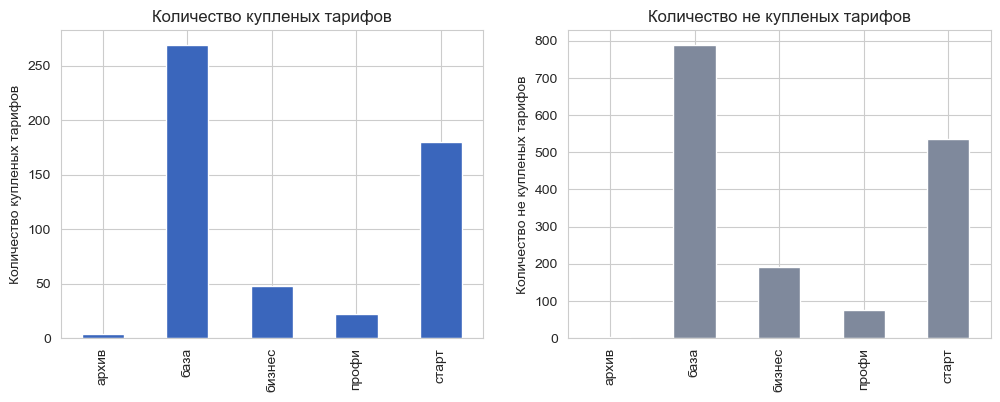

In [101]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

billing2324[billing2324['is_payed']==True].groupby('tariff_cat')['company_id'].count().plot.bar(color=colors[0], ax=ax[0])
billing2324[billing2324['is_payed']!=True].groupby('tariff_cat')['company_id'].count().plot.bar(color=colors[1], ax=ax[1])


ax[0].set(xlabel='название тарифа', ylabel='Количество купленых тарифов', title='Количество купленых тарифов')
ax[1].set(xlabel='название тарифа', ylabel='Количество не купленых тарифов', title='Количество не купленых тарифов')
ax[0].set_xlabel(None)
ax[1].set_xlabel(None);

Посмотрим динамику по датам

In [102]:
billing2324.loc[:,'created_at_M']=pd.to_datetime(billing2324['created_at']).dt.strftime('%Y-%m')
billing2324.insert(8,'created_at_M',billing2324.pop('created_at_M'))

In [103]:
tariff = list(billing2324['tariff_cat'].unique())

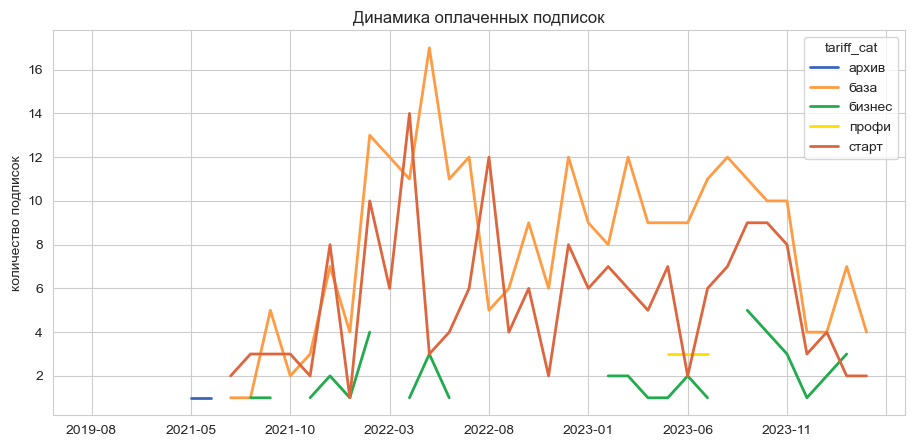

In [104]:
fig, ax = plt.subplots(figsize=(11,5))
billing2324[billing2324['is_payed']==True].groupby(['created_at_M','tariff_cat'] ).agg(cnt = ('tariff_cat', 'count')).reset_index().\
pivot(index='created_at_M', columns='tariff_cat', values='cnt').plot(color=colors1, linewidth = 2, ax=ax)
plt.title('Динамика оплаченных подписок')
plt.ylabel('количество подписок')
plt.xlabel(None);

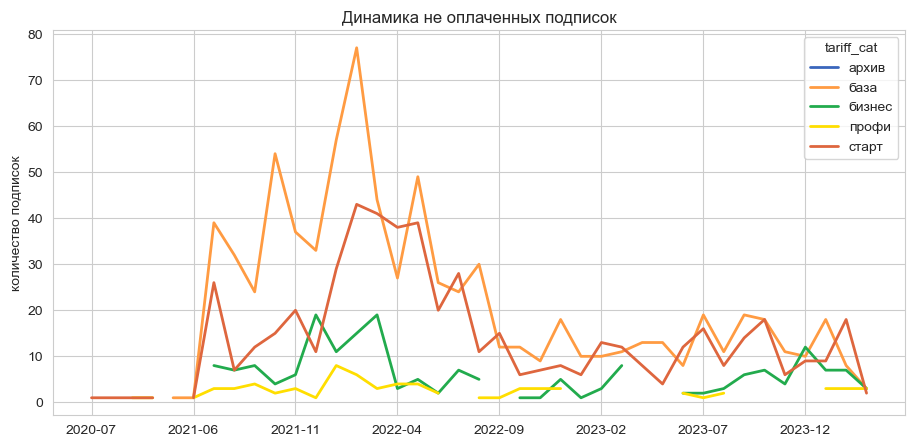

In [105]:
fig, ax = plt.subplots(figsize=(11,5))
billing2324[billing2324['is_payed']==False].groupby(['created_at_M','tariff_cat'] ).agg(cnt = ('tariff_cat', 'count')).reset_index().\
pivot(index='created_at_M', columns='tariff_cat', values='cnt').plot(color=colors1, linewidth = 2, ax=ax)
plt.title('Динамика не оплаченных подписок')
plt.ylabel('количество подписок')
plt.xlabel(None);

В целом можно сказать, что наибольшим спросом пользуются тарифы базовый и стартовый. В начале 2022 года было заявлено много подписок, которые не оплачивали.
Возможно была рекламная компания, которая привлекла много новых клиентов, которые решили не использовать сервис.

Зададим дату, на основании которой будем считать ушел ли клиент или остался. За сегодняшнюю дату принимаем дату начала проекта 28.03.2024

In [106]:
analyse_date = dt.datetime(2024,3,28)
print(analyse_date)

2024-03-28 00:00:00


In [107]:
# дата окончания последнего договора компании
billing2324['last_date'] = billing2324.groupby('company_id')['payed_until'].transform('max')
billing2324.insert(6,'last_date', billing2324.pop('last_date'))

In [108]:
# проверка для одной компании
billing2324[billing2324['company_id'] == 21]

,id,user_id,company_id,billing_tariff_id,tariff_cat,payed_until,last_date,is_payed,created_at,created_at_M,updated_at,billing_tariff_price_id,comment,pay_date
2170,7908,24,21,7,старт,2023-04-04,2023-05-27,False,2022-04-04 13:16:56,2022-04,2022-04-04 13:16:59,23,NaN,NaT
2748,9919,24,21,7,старт,2023-05-27,2023-05-27,True,2023-01-03 09:25:25,2023-01,2023-05-27 08:36:31,23,NaN,2023-05-27
2935,9973,24,21,7,старт,2023-04-30,2023-05-27,True,2023-01-12 12:43:51,2023-01,2023-04-28 13:13:05,23,был до 19.01.2024,2023-01-19


Нельзя считать, что клиент остался, если у него оплачен именно последний договор. Возможно он его оформил, но еще не платил и пользуется старым. Но хотя бы один договор у фирмы должен быть оплачен. Иначе она не является клиентом вообще. 

Данные собраны не очень корректно. Есть столбец дата платежа. Но так же есть строки, где в этом столбце есть данные, но при этом статус платежа отрицательный. Будем считать именно этот столбец - статус платежа (is_payed) главным. И даже есть в дате платежа есть значение, но статут платежа отрицательный, считаем платеж не прошедшим. 

Этот момент требует внимания. На его снове в т.ч. принимается решение, считать ли клиента ушедшим или активным.

In [109]:
company_id_payed = list(billing2324[billing2324['is_payed'].isin([True])]['company_id'].unique())

In [110]:
billing2324['churn'] = np.where(((analyse_date - billing2324.last_date) / pd.Timedelta('1D') <= 0)  & (billing2324.company_id.isin(company_id_payed)),0,1)
billing2324.insert(3,'churn', billing2324.pop('churn'))

In [111]:
# проверка для одной компании
billing2324[billing2324['company_id'] == 7526]

,id,user_id,company_id,churn,billing_tariff_id,tariff_cat,payed_until,last_date,is_payed,created_at,created_at_M,updated_at,billing_tariff_price_id,comment,pay_date
2888,10554,10091,7526,0,2,база,2024-03-29,2024-04-30,False,2023-03-29 08:04:55,2023-03,2023-03-29 08:05:01,8,NaN,NaT
3460,10566,10091,7526,0,2,база,2024-03-06,2024-04-30,True,2023-03-30 08:17:57,2023-03,2024-03-06 09:25:07,8,"12+1 до 30,04,24\r\n06,03,24 сменили тариф со св графиком (тариф был до 30,04,24)",2023-03-30 00:00:00
3466,13589,10091,7526,0,17,база,2024-03-13,2024-04-30,True,2024-03-06 09:22:48,2024-03,2024-03-13 10:26:04,15,06.03.24- Cсв гр на неделю,2024-03-06 00:00:00
3479,18932,10091,7526,0,2,база,2024-04-30,2024-04-30,True,2024-03-13 10:24:06,2024-03,2024-03-13 10:26:17,8,"13,03,24- убрали сводный график",2024-03-13 10:26:17


Таким образом целевая переменная выбрана так: считаем, что фирма не ушла, если она оплачивала хотя бы 1 договор и срок последнего договора (может быть и не оплаченного) не истекает на дату анализа.
Что бы понять, что приводит к оттоку будем анализировать файл с активностями и информацию по компаниям, собранным в отдельном датасете. 

Добавим в датасет с активностями для каждой фирмы значение целевой переменной.

In [112]:
df = activ2324.merge(billing2324[['company_id','churn']], how = 'left', on =  'company_id')
df.insert(2,'churn',df.pop('churn'))
df.churn = df.churn.astype('Int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   company_id                     5028 non-null   int64 
 1   month                          5028 non-null   object
 2   churn                          5020 non-null   Int32 
 3   company-month-billing          5028 non-null   int64 
 4   company-month-stocks           5028 non-null   int64 
 5   company-month-backups          5028 non-null   int64 
 6   company-month-projects         5028 non-null   int64 
 7   company-month-contractors      5028 non-null   int64 
 8   company-month-resource_orders  5028 non-null   int64 
dtypes: Int32(1), int64(7), object(1)
memory usage: 338.9+ KB


Для 8 фирм не удалось обозначить целевую переменную, посмотрим, что  это за фирмы

In [113]:
company_no_churn = list(df[df['churn'].isnull()]['company_id'].unique())
company_no_churn

[336, 1881, 1935, 2755, 3348, 4072]

Проверим, есть ли данные по этим фирмам в других таблицах?

In [114]:
billing2324[billing2324['company_id'].isin(company_no_churn)]

,id,user_id,company_id,churn,billing_tariff_id,tariff_cat,payed_until,last_date,is_payed,created_at,created_at_M,updated_at,billing_tariff_price_id,comment,pay_date


In [115]:
billing[billing['company_id'].isin(company_no_churn)]

,id,user_id,company_id,billing_tariff_id,tariff_cat,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
99,3230,2238,1935,2,база,2021-06-10,True,2021-01-19 14:45:42,2021-06-10 09:24:43,8,"возврат 2,03,21",2021-01-22 00:00:00
135,3325,3229,2755,2,база,2022-03-12,True,2021-01-29 14:04:47,2021-02-02 08:35:21,8,"02,02 - клиенту было предложено +1 мес в подарок в связи с недопониманием, сменила с 12,02,22 по 12,03,22",2021-01-29 00:00:00
619,4147,4041,3348,2,база,2021-12-01,True,2021-05-17 12:44:40,2021-05-21 15:38:23,7,NaN,2021-05-21 15:38:23
806,734,372,336,4,старт,2020-01-10,True,2019-12-09 12:44:51,2019-12-10 06:28:45,13,NaN,NaT
1111,2317,2175,1881,7,старт,2021-10-09,True,2020-09-30 10:58:32,2020-09-30 10:58:53,23,NaN,NaT
1545,6307,4041,3348,7,старт,2022-11-24,False,2021-11-24 11:24:44,2021-11-24 11:24:48,23,NaN,NaT
1906,6925,5068,4072,2,база,2022-08-11,True,2022-01-21 09:53:38,2022-02-11 10:45:28,7,"11.02.22 - 6 мес активаци\r\nперенесли 11,02 на другой аккаунт данного пользователя",2022-02-11 00:00:00


In [116]:
companies[companies['company_id'].isin(company_no_churn)]

,company_id,working_direction,working_direction_cat,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
149,1935,,н/д,1,2020-10-05 07:43:00,2023-02-11 22:00:01,2,True
150,2755,ремонтные работы,ремонт,1,2021-01-28 14:33:29,2023-07-02 22:00:02,2,True
207,3348,,н/д,1,2021-05-17 08:33:49,2023-08-25 22:00:02,2,True
350,4072,,н/д,2,2021-08-28 13:31:58,2024-01-20 22:00:02,2,True
560,1881,,н/д,1,2020-09-24 15:26:00,2023-06-01 22:00:02,7,True
649,336,строительство,строительство,1,2019-06-21 17:28:38,2023-06-10 22:00:02,4,True


In [117]:
people[people['company_id'].isin(company_no_churn)]

,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,updated_day
41,8780,1935,<NA>,27634,2021-01-18 16:44:06,2021-01-18 16:44:06,True,2021-01-26 16:56:47,0.00
155,8781,1935,3121,27634,2021-01-18 17:36:05,2021-01-18 19:01:14,False,NaT,0.06
160,8775,1935,3124,27636,2021-01-18 16:26:26,2021-01-27 15:16:16,False,NaT,8.95
260,8776,1935,3120,27634,2021-01-18 16:27:15,2021-01-18 17:30:48,False,NaT,0.04
285,7689,1881,2175,1,2020-09-24 15:26:01,2020-09-24 15:26:01,False,NaT,0.00
298,7696,1881,2179,1,2020-09-26 07:40:59,2020-09-28 13:19:53,False,NaT,2.24
331,7759,1935,2238,1,2020-10-05 07:43:00,2020-10-05 07:43:00,False,NaT,0.00
345,8777,1935,<NA>,27636,2021-01-18 16:31:21,2021-01-27 15:16:33,False,NaT,8.95
423,8778,1935,3123,38053,2021-01-18 16:33:51,2021-01-27 15:16:55,False,NaT,8.95
426,8915,2755,3232,1,2021-01-28 14:44:14,2021-01-28 14:46:12,False,NaT,0.00


Эти 8 фирм имеют договор, закончившийся до 2023 года, следовательно они ушли. Можно назначить им значение параметра churn = 1

In [118]:
df['churn'] = np.where(df['company_id'].isin(company_no_churn),1,df['churn'])

In [119]:
df.churn = df.churn.astype('Int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   company_id                     5028 non-null   int64 
 1   month                          5028 non-null   object
 2   churn                          5028 non-null   Int32 
 3   company-month-billing          5028 non-null   int64 
 4   company-month-stocks           5028 non-null   int64 
 5   company-month-backups          5028 non-null   int64 
 6   company-month-projects         5028 non-null   int64 
 7   company-month-contractors      5028 non-null   int64 
 8   company-month-resource_orders  5028 non-null   int64 
dtypes: Int32(1), int64(7), object(1)
memory usage: 338.9+ KB


In [120]:
activ2324.shape

(2385, 8)

In [121]:
df.duplicated().sum()

2643

После объединения таблиц появились дубликаты - уберем их

In [122]:
df = df.drop_duplicates()

In [123]:
df['company_id'].nunique()

366

Сделаем расшифровку признаков для удобства. И соберем общую статистику по компаниям, без разбивки по месяцам.

In [124]:
dict_to_rus = {
'churn': 'компания ушла (1/0)',
'company_billing': 'кол-во счетов, выставленных в приложении компанией',
'company_stocks': 'кол-во складов (аренда, заказы и т.д.), используемых компанией',
'company_backups': 'кол-во бэкапов компании',
'company_projects': 'кол-во проектов компании',
'company_contractors': 'кол-во контрагентов компании',
'company_resource_orders': 'кол-во заказов материалов компании'} 

In [125]:
pd.DataFrame(list(dict_to_rus.values()), index = list(dict_to_rus.keys()), columns = ['Расшифровка'])

,Расшифровка
churn,компания ушла (1/0)
company_billing,"кол-во счетов, выставленных в приложении компанией"
company_stocks,"кол-во складов (аренда, заказы и т.д.), используемых компанией"
company_backups,кол-во бэкапов компании
company_projects,кол-во проектов компании
company_contractors,кол-во контрагентов компании
company_resource_orders,кол-во заказов материалов компании


In [126]:
df_all = df.groupby('company_id').agg(churn = ('churn', 'max'), company_billing = ('company-month-billing', 'sum'), company_stocks = ('company-month-stocks', 'sum'),\
                            company_backups = ('company-month-backups', 'sum'), company_projects = ('company-month-projects', 'sum'),\
                            company_contractors = ('company-month-contractors', 'sum'), company_resource_orders = ('company-month-resource_orders', 'sum')).reset_index()
df_all = df_all.drop('company_id', axis = 1)
df_all

,churn,company_billing,company_stocks,company_backups,company_projects,company_contractors,company_resource_orders
0,1,2,32,0,32,70,14
1,1,1,2,0,2,5,2
2,1,1,5,0,5,4,0
3,0,0,11,59,11,245,335
4,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...
361,0,3,2,0,2,3,8
362,0,2,23,0,23,7,9
363,0,2,12,0,11,5,9
364,0,2,13,0,13,5,5


**Изучение средних по группам**

На данном этапе исследуем средние оценки по группам (остался/ушел).
- В качестве оценок средних воспользуемся выборочным средним и медианой.
- Для наглядности и удобства анализа рассчитаем также средние оценки по всей выборке.

Выборочные средние и медианы по всей выборке без признака churn

In [127]:
df_mean_full = df_all.drop('churn', axis = 1).agg('mean')
df_median_full = df_all.drop('churn', axis = 1).agg('median')

Выборочные средние и медианы по группам (остался/ушел)

In [128]:
df_mean = df_all.groupby('churn').agg('mean').T
df_median = df_all.groupby('churn').agg('median').T

Соберем оценки в единый датафрейм и установим заголовки столбцов

In [129]:
df_temp = pd.concat([df_mean_full, df_median_full, df_mean, df_median], axis = 1)
df_temp.columns = ['mean_full', 'median_full', 'mean_not_churn', 
                   'mean_churn', 
                   'median_not_churn', 
                   'median_churn']

Для удобства интерпретации добавим расшифровку признаков

In [130]:
(pd.concat([pd.DataFrame(list(dict_to_rus.values()), index = list(dict_to_rus.keys()), columns = ['расшифровка']), 
           df_temp], axis = 1, sort = False, join = 'inner'))

,расшифровка,mean_full,median_full,mean_not_churn,mean_churn,median_not_churn,median_churn
company_billing,"кол-во счетов, выставленных в приложении компанией",1.61,2.00,1.92,1.03,2.00,1.00
company_stocks,"кол-во складов (аренда, заказы и т.д.), используемых компанией",45.76,16.50,58.78,22.12,25.50,7.00
company_backups,кол-во бэкапов компании,6.29,0.00,8.08,3.03,0.00,0.00
company_projects,кол-во проектов компании,49.48,17.00,63.10,24.75,25.50,7.00
company_contractors,кол-во контрагентов компании,61.59,15.00,86.07,17.15,29.00,3.00
company_resource_orders,кол-во заказов материалов компании,93.35,7.00,136.90,14.30,13.50,1.00


По всем признакам видно, что ушедшие компании были менее активны в приложении, чем те, кто остался. Компании, которые остались, пользуются приложением по всем показателям больше, чем в среднем.
Следовательно можно предположить, что оставшиеся в приложении компании пользуются им активно. 

Посмотрим, какие виды деятельности преобладают среди пользователей приложения. Для этого добавим сферу деятельности фирмы к ее id

In [131]:
df_working = billing2324[['company_id','churn']].merge(companies[['company_id','working_direction_cat']], how = 'left', on =  'company_id')
df_working

,company_id,churn,working_direction_cat
0,3785,1,NaN
1,4132,1,NaN
2,4145,1,NaN
3,2462,0,NaN
4,3277,1,строительство
...,...,...,...
2113,10848,1,NaN
2114,4004,0,NaN
2115,9841,1,NaN
2116,7745,0,н/д


In [132]:
billing2324['company_id'].nunique()

1283

In [133]:
df_working['company_id'].nunique()

1283

In [134]:
df_working.duplicated().sum()

835

In [135]:
df_working = df_working.drop_duplicates ()

In [136]:
df_working.shape

(1283, 3)

In [137]:
df_working.pivot_table(index='working_direction_cat', columns='churn', values='company_id', aggfunc = 'count')

churn,0,1
working_direction_cat,,
дизайн,NaN,1.00
другое,14.00,15.00
н/д,152.00,117.00
производство,1.00,1.00
ремонт,7.00,8.00
строительство,67.00,45.00
строительство и ремонт,6.00,6.00


К сожалению, сфера деятельности указана у небольшого кол-ва фирм. Поэтому сделать вывод сложно. Но, из тех данных. что мы имеем, видно, что оставшихся больше всего в сфере строительства и там. где сфера деятельности не указана.

Посмотрим длительность подписки у тех кто ушел и те, кто остался. Будем считать месяц примерный - 30 дней. Округлим до целого значения.


In [138]:
billing2324['sub_m'] = round((billing2324.payed_until- billing2324.created_at) / pd.Timedelta( 30 , 'D'))
billing2324.insert(8,'sub_m', billing2324.pop('sub_m'))
billing2324 = billing2324.astype({'sub_m':'int64'}, errors='ignore')

In [139]:
billing2324.groupby('churn').agg(month_quantity= ('sub_m', set)).reset_index()



,churn,month_quantity
0,0,"{0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 150, 22, 24, 25, 23, 27, 28, 29, 30, 31, 32, 33, 26, 35, 38, 39, 40, 41, ..."
1,1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 33, 34, 36, 42, 59, 111}"


In [140]:
billing2324['sub_m'].nunique()

55

In [141]:
billing2324['sub_m'].value_counts()

sub_m
18     585
12     523
24     427
13      88
0       50
20      48
14      45
21      44
1       26
15      22
28      22
29      20
22      20
6       19
2       16
25      16
16      15
3       15
23      10
31      10
19       8
10       7
17       7
30       7
4        6
5        6
11       6
26       5
8        5
9        4
33       3
38       2
48       2
43       2
59       2
7        2
42       2
32       2
41       2
35       2
39       1
55       1
40       1
36       1
150      1
27       1
46       1
45       1
68       1
66       1
111      1
34       1
61       1
99       1
47       1
Name: count, dtype: int64

In [142]:
# проверка максимального значения 150 месяцев
billing2324[billing2324['sub_m']==150]

,id,user_id,company_id,churn,billing_tariff_id,tariff_cat,payed_until,last_date,sub_m,is_payed,created_at,created_at_M,updated_at,billing_tariff_price_id,comment,pay_date
101,3047,567,512,0,7,старт,2033-04-10 23:59:59,2033-04-10 23:59:59,150,False,2020-12-21 15:05:06,2020-12,2020-12-21 15:05:06,23,NaN,NaT


Количество вариантов подписок большое - 55 вариантов, но больше всего значений в позициях 18, 12 и 24 месяца. Не будем убирать пока выборосы, создадим категории для подписок:

- 0, <6, 6-12, 12-18, 18-24, 24-30, 30+ месяцев. 

Левые границы НЕ входят в диапазон.

In [143]:
billing2324['sub_m_cat'] = pd.cut(
  billing2324['sub_m'],
  bins=[-1, 0, 6, 12, 18, 24, 30, 200],
  labels=['0','<6', '6-12', '12-18', '18-24', '24-30', '30+']
)
billing2324.insert(9,'sub_m_cat', billing2324.pop('sub_m_cat'))

In [144]:
billing2324.groupby('churn').agg(month_quantity= ('sub_m_cat', set)).reset_index()

,churn,month_quantity
0,0,"{12-18, <6, 6-12, 24-30, 30+, 18-24, 0}"
1,1,"{12-18, <6, 6-12, 24-30, 30+, 18-24, 0}"


Все группы представлены как у ушедших, так и оставшихся компаний. Посмотрим на количество.


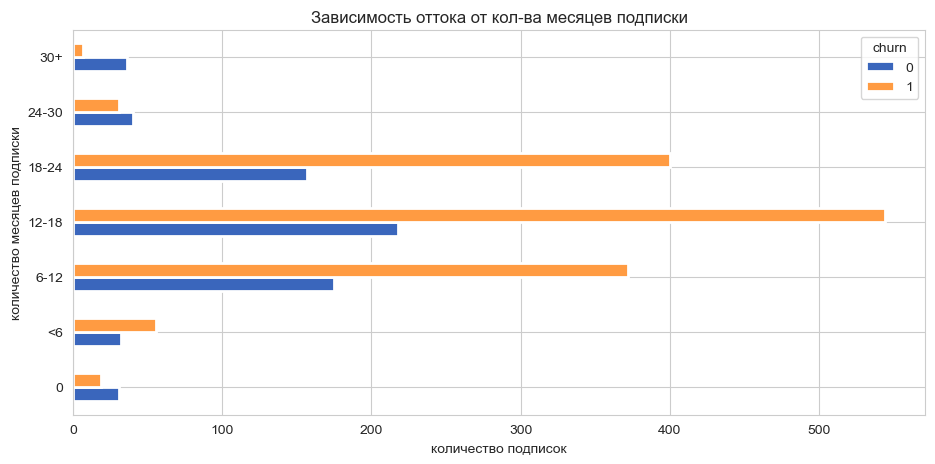

In [145]:
fig, ax = plt.subplots(figsize=(11,5))
billing2324[['churn', 'sub_m_cat']].value_counts().reset_index().pivot(index='sub_m_cat', columns='churn', values='count').plot(kind="barh", color=colors1, linewidth = 2, ax=ax)
plt.title('Зависимость оттока от кол-ва месяцев подписки')
plt.xlabel('количество подписок')
plt.ylabel('количество месяцев подписки');

- В целом пока нельзя сделать вывод, что время подписки как то влияет на отток. Общее кол-во подписок у ушедших компаний больше. Только в категориях `более 24 месяцев`  и `менее, чем на месяц` кол-во подписок у оставшихся больше. Но по общему количеству это небольшие категории. 
Посмотрим в % соотношении. 


In [146]:
df = billing2324[['company_id', 'churn', 'sub_m_cat']].pivot_table(index='sub_m_cat', columns='churn', aggfunc='count').reset_index()
df.columns = ['sub_m_cat', 'churn_0', 'churn_1']

In [147]:
df['churn_0_%'] = df['churn_0']/df['churn_0'].sum()*100
df['churn_1_%'] = df['churn_1']/df['churn_1'].sum()*100

In [148]:
df

,sub_m_cat,churn_0,churn_1,churn_0_%,churn_1_%
0,0,31,19,4.50,1.33
1,<6,32,56,4.64,3.92
2,6-12,175,372,25.40,26.03
3,12-18,218,544,31.64,38.07
4,18-24,157,400,22.79,27.99
5,24-30,40,31,5.81,2.17
6,30+,36,7,5.22,0.49


В процентном соотношении данные по основным категориям (с 6 до 24 месяцев) выровнились, а малочисленных категориях (менее 1 месяца  и более 24 ) % у оставшихся больше.
Практической пользы эта информация не несет. Жаль.

При оценке данных была выделена группа компаний с максимальными активностями. Посмотрим, какой % оттока у этих компаний.

In [149]:
billing2324[billing2324['company_id'].isin(id_company_max)]['churn'].value_counts()

churn
0    285
1    104
Name: count, dtype: int64

В этой категории оствшихся компаний больше почти в 2 раза. Что еще раз доказывает, что компании, которые активно пользуются приложением  - активные клиенты.

Посмотрим, насколько часто менялся тариф у компаний.

In [150]:
df = billing2324.groupby(['churn','company_id'] ).agg({'tariff_cat': set}).reset_index()
df['tariff_cat_cnt'] = df['tariff_cat'].apply(lambda x: len(x))
df

,churn,company_id,tariff_cat,tariff_cat_cnt
0,0,5,"{база, старт, профи}",3
1,0,408,{база},1
2,0,495,{база},1
3,0,512,"{база, старт}",2
4,0,628,{старт},1
...,...,...,...,...
1278,1,9976,{профи},1
1279,1,10010,{старт},1
1280,1,10077,{старт},1
1281,1,10848,"{база, бизнес}",2


In [151]:
df.groupby('churn').agg({'tariff_cat_cnt': ['mean', 'median']})

tariff_cat_cnt       
                mean median
churn                      
0               1.27   1.00
1               1.07   1.00

У оставшихся компаний чуть больше средее значение смены тарифа, но медианное значение по всем данным - 1. Следовательно большинство компаний тариф не меняло.
Речь идет именно о тарифной ставке (стоимости). Внутри тарифа могли происходить какие то изменения, но на переход от одного тарифа на другой это не влияет.

Посмотрим компании с макимальным кол-вом смен тарифов. 

In [152]:
df['tariff_cat_cnt'].unique()

array([3, 1, 2, 4, 5], dtype=int64)

In [153]:
df[df['tariff_cat_cnt']==5]['company_id']

119    6639
Name: company_id, dtype: int64

In [154]:
billing2324[billing2324['company_id']==6639]

,id,user_id,company_id,churn,billing_tariff_id,tariff_cat,payed_until,last_date,sub_m,sub_m_cat,is_payed,created_at,created_at_M,updated_at,billing_tariff_price_id,comment,pay_date
2630,9556,8704,6639,0,10,профи,2024-09-13 23:59:59,2025-08-27 23:59:59,23,18-24,False,2022-10-27 11:47:10,2022-10,2022-10-27 11:47:10,32,NaN,NaT
2631,9557,8704,6639,0,7,старт,2024-09-13 23:59:59,2025-08-27 23:59:59,23,18-24,False,2022-10-27 11:47:54,2022-10,2022-10-27 11:47:54,23,NaN,NaT
2776,10097,8704,6639,0,6,архив,2023-07-27 00:00:00,2025-08-27 23:59:59,6,<6,False,2023-01-27 07:21:37,2023-01,2023-01-27 07:21:44,17,NaN,NaT
2777,10098,8704,6639,0,6,архив,2023-07-27 00:00:00,2025-08-27 23:59:59,6,<6,False,2023-01-27 07:22:14,2023-01,2023-01-27 07:22:25,17,NaN,NaT
2910,10700,8704,6639,0,13,профи,2025-07-31 23:59:59,2025-08-27 23:59:59,28,24-30,False,2023-04-12 08:59:28,2023-04,2023-04-12 08:59:28,43,NaN,NaT
2911,10701,8704,6639,0,4,старт,2023-07-12 00:00:00,2025-08-27 23:59:59,3,<6,False,2023-04-12 09:04:06,2023-04,2023-04-12 09:04:11,14,NaN,NaT
3088,11666,8704,6639,0,2,база,2025-08-27 23:59:59,2025-08-27 23:59:59,25,24-30,False,2023-08-10 08:22:29,2023-08,2023-08-10 08:22:29,8,NaN,NaT
3232,12514,8704,6639,0,9,бизнес,2025-03-01 23:59:59,2025-08-27 23:59:59,16,12-18,False,2023-10-26 10:30:18,2023-10,2023-10-26 10:30:18,29,NaN,NaT
3261,12641,8704,6639,0,9,бизнес,2025-01-19 23:59:59,2025-08-27 23:59:59,15,12-18,False,2023-11-08 12:08:10,2023-11,2023-11-08 12:08:10,29,NaN,NaT
3337,13035,8704,6639,0,9,бизнес,2025-01-26 23:59:59,2025-08-27 23:59:59,13,12-18,False,2023-12-29 10:00:12,2023-12,2023-12-29 10:00:12,29,NaN,NaT


In [155]:
billing[billing['company_id']==6639]

,id,user_id,company_id,billing_tariff_id,tariff_cat,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
2630,9556,8704,6639,10,профи,2024-09-13 23:59:59,False,2022-10-27 11:47:10,2022-10-27 11:47:10,32,NaN,NaT
2631,9557,8704,6639,7,старт,2024-09-13 23:59:59,False,2022-10-27 11:47:54,2022-10-27 11:47:54,23,NaN,NaT
2776,10097,8704,6639,6,архив,2023-07-27 00:00:00,False,2023-01-27 07:21:37,2023-01-27 07:21:44,17,NaN,NaT
2777,10098,8704,6639,6,архив,2023-07-27 00:00:00,False,2023-01-27 07:22:14,2023-01-27 07:22:25,17,NaN,NaT
2910,10700,8704,6639,13,профи,2025-07-31 23:59:59,False,2023-04-12 08:59:28,2023-04-12 08:59:28,43,NaN,NaT
2911,10701,8704,6639,4,старт,2023-07-12 00:00:00,False,2023-04-12 09:04:06,2023-04-12 09:04:11,14,NaN,NaT
3088,11666,8704,6639,2,база,2025-08-27 23:59:59,False,2023-08-10 08:22:29,2023-08-10 08:22:29,8,NaN,NaT
3232,12514,8704,6639,9,бизнес,2025-03-01 23:59:59,False,2023-10-26 10:30:18,2023-10-26 10:30:18,29,NaN,NaT
3261,12641,8704,6639,9,бизнес,2025-01-19 23:59:59,False,2023-11-08 12:08:10,2023-11-08 12:08:10,29,NaN,NaT
3337,13035,8704,6639,9,бизнес,2025-01-26 23:59:59,False,2023-12-29 10:00:12,2023-12-29 10:00:12,29,NaN,NaT


Данные очень странные. Проверка по данным (2023-20234 год) и по всем у датасету говорит о том, что компания появившись в октябре 2022 года поменяла за это время все возможные тарифы, но оплатила только последний. Вопрос к данным:  они не отображают пробный бесплатный период пользования ( 7 дней)? Тогда возможно компания выбирала все  бесплатные периоды у каждого тарифа и в конце концов остановилась на тарифе профи, причем оплатила его на 25 месяцев.


Посмотрим на ее активность


In [156]:
activ2324[activ2324['company_id']==6639]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


In [157]:
activities[activities['company_id']==6639]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


Активности у фирмы нет никакой. Или эти данные не отображались в системе.

Посмотрим еще компании, которые меняли тариф 4 раза

In [158]:
company_id_4 = list(df[df['tariff_cat_cnt']==4]['company_id'])
company_id_4

[2462, 4004, 3260, 3276]

In [159]:
billing2324[billing2324['company_id']==2462]

,id,user_id,company_id,churn,billing_tariff_id,tariff_cat,payed_until,last_date,sub_m,sub_m_cat,is_payed,created_at,created_at_M,updated_at,billing_tariff_price_id,comment,pay_date
40,8966,2838,2462,0,7,старт,2023-07-25 00:00:00,2027-09-03 23:59:59,12,6-12,False,2022-07-25 12:35:03,2022-07,2022-07-25 12:35:06,23,NaN,NaT
68,5102,2838,2462,0,2,база,2023-08-12 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-08-12 13:50:01,2021-08,2021-08-12 13:50:04,35,NaN,NaT
203,5252,2838,2462,0,2,база,2023-08-26 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-08-26 14:50:16,2021-08,2021-08-26 14:50:18,35,NaN,NaT
246,4878,2838,2462,0,9,бизнес,2023-07-22 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-07-22 13:50:39,2021-07,2021-07-22 13:50:42,36,NaN,NaT
314,4639,2838,2462,0,10,профи,2023-07-02 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-07-02 16:32:01,2021-07,2021-07-02 16:32:03,37,NaN,NaT
420,4720,2838,2462,0,2,база,2023-07-09 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-07-09 10:29:06,2021-07,2021-07-09 10:29:31,35,NaN,NaT
638,5059,2838,2462,0,9,бизнес,2023-08-09 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-08-09 15:35:09,2021-08,2021-08-09 15:35:13,36,NaN,NaT
643,5074,2838,2462,0,2,база,2023-08-10 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-08-10 13:54:51,2021-08,2021-08-10 13:54:54,35,NaN,NaT
725,5214,2838,2462,0,10,профи,2023-08-24 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-08-24 07:28:35,2021-08,2021-08-24 07:28:39,37,NaN,NaT
1282,5580,2838,2462,0,10,профи,2023-09-22 00:00:00,2027-09-03 23:59:59,24,18-24,False,2021-09-22 14:31:35,2021-09,2021-09-22 14:31:38,37,NaN,NaT


In [160]:
activ2324[activ2324['company_id']==2462]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


In [161]:
activities[activities['company_id']==2462]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


У этой фирмы тоже нет информации в активностях. Проверим оставшиеся 3 фирмы.

In [162]:
billing2324[billing2324['company_id']==4004]

,id,user_id,company_id,churn,billing_tariff_id,tariff_cat,payed_until,last_date,sub_m,sub_m_cat,is_payed,created_at,created_at_M,updated_at,billing_tariff_price_id,comment,pay_date
555,5347,4980,4004,0,2,база,2023-12-02 00:00:00,2025-06-29,27,24-30,True,2021-09-02 11:02:03,2021-09,2022-11-25 13:41:51,7,NaN,2021-09-02
1344,5770,4980,4004,0,2,база,2023-10-11 00:00:00,2025-06-29,24,18-24,False,2021-10-11 12:14:13,2021-10,2021-10-11 12:14:18,35,NaN,NaT
1345,5771,4980,4004,0,2,база,2023-10-11 00:00:00,2025-06-29,24,18-24,False,2021-10-11 12:21:44,2021-10,2021-10-11 12:21:48,35,NaN,NaT
1568,6375,4980,4004,0,2,база,2023-12-01 00:00:00,2025-06-29,24,18-24,False,2021-12-01 16:23:08,2021-12,2021-12-01 16:23:34,35,NaN,NaT
1719,6783,4980,4004,0,7,старт,2023-07-13 00:00:00,2025-06-29,18,12-18,False,2022-01-13 14:39:03,2022-01,2022-01-13 14:39:10,26,NaN,NaT
2003,9178,4980,4004,0,9,бизнес,2023-08-19 00:00:00,2025-06-29,12,6-12,False,2022-08-19 09:22:30,2022-08,2022-08-19 09:22:34,29,NaN,NaT
2227,9150,4980,4004,0,2,база,2024-08-17 00:00:00,2025-06-29,24,18-24,False,2022-08-17 11:24:51,2022-08,2022-08-17 11:24:55,35,NaN,NaT
2387,9046,4980,4004,0,2,база,2024-02-03 00:00:00,2025-06-29,18,12-18,False,2022-08-03 10:29:35,2022-08,2022-08-03 10:29:40,24,NaN,NaT
2511,8897,4980,4004,0,9,бизнес,2024-01-14 00:00:00,2025-06-29,18,12-18,False,2022-07-14 14:58:19,2022-07,2022-07-14 14:58:25,30,NaN,NaT
2596,9392,4980,4004,0,2,база,2023-09-26 00:00:00,2025-06-29,12,6-12,False,2022-09-26 09:59:38,2022-09,2022-09-26 09:59:42,8,NaN,NaT


In [163]:
activities[activities['company_id']==4004]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


In [164]:
activities[activities['company_id']==3260]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


In [165]:
activities[activities['company_id']==3276]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders


В целом ситуация такая: фирмы, меняющие тариф многократно ( 4 и 5 раз) не вели вообще никакой активности за все время нахождения в программе. Покупка (проверены 2 фирмы  из 5, у них тариф оплачен) возможно и была , но никакой деятельности в программе фирма не вела. Смысл покупки и метания по тарифам не понятен.
Требуется проверка правильности выгрузки данных по активностям. Тот результат, который имеется на сегодняшний день не логичен. Покупать дорогую подписку на большой срок и не пользоваться программой  - сомнительная покупка. 

In [166]:
df_all

,churn,company_billing,company_stocks,company_backups,company_projects,company_contractors,company_resource_orders
0,1,2,32,0,32,70,14
1,1,1,2,0,2,5,2
2,1,1,5,0,5,4,0
3,0,0,11,59,11,245,335
4,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...
361,0,3,2,0,2,3,8
362,0,2,23,0,23,7,9
363,0,2,12,0,11,5,9
364,0,2,13,0,13,5,5


Выделим интервальные признаки в активностях и построим распределения 

In [167]:
intrvl_var = ['company_billing', 'company_stocks', 'company_backups', 'company_projects', 'company_contractors', 'company_resource_orders']

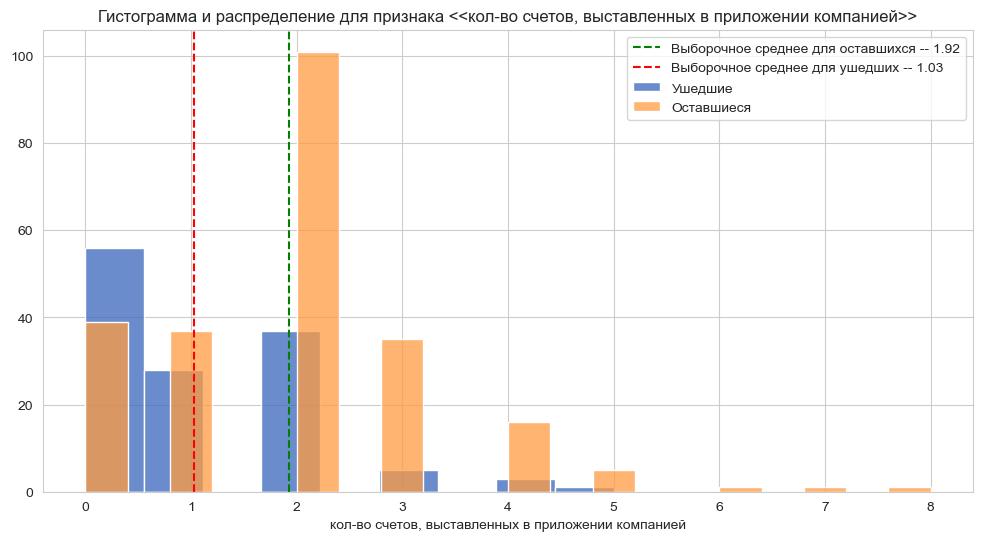

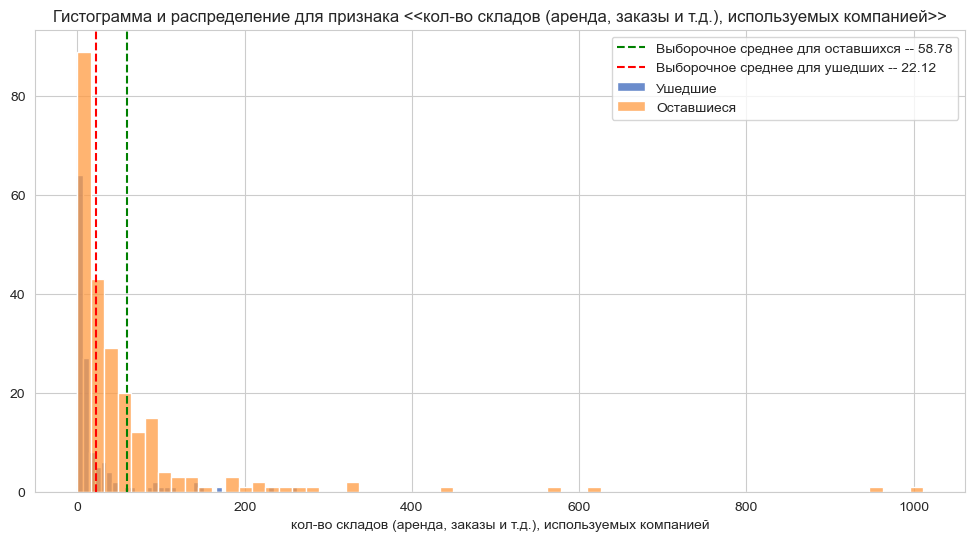

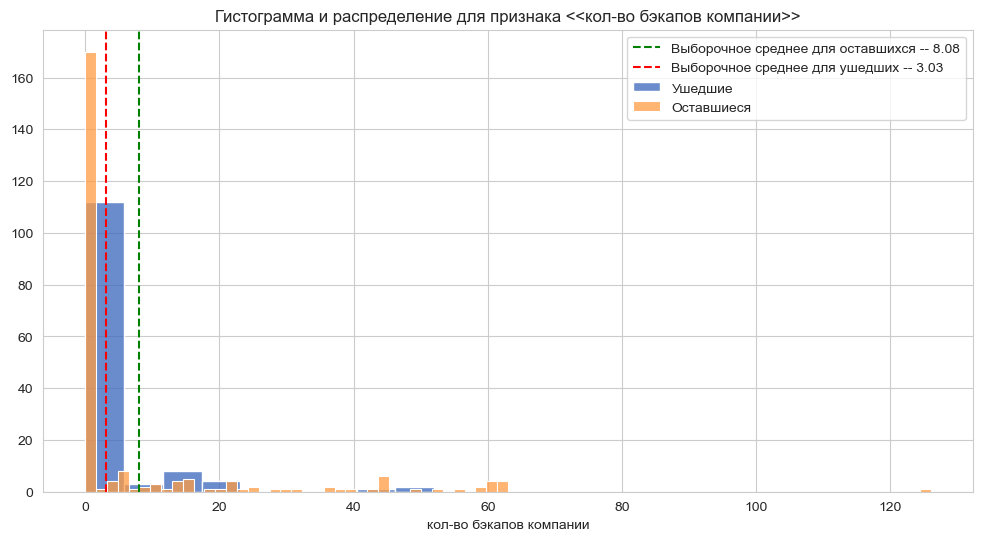

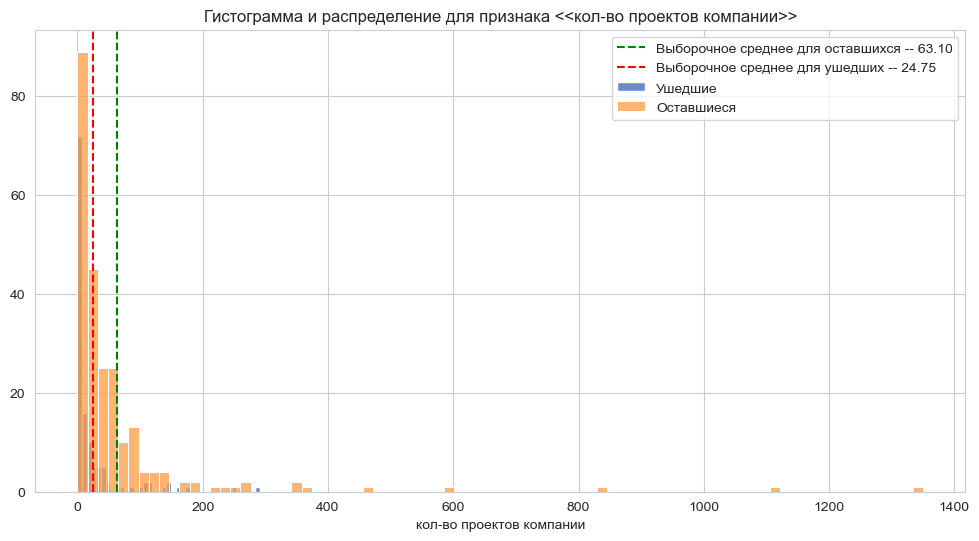

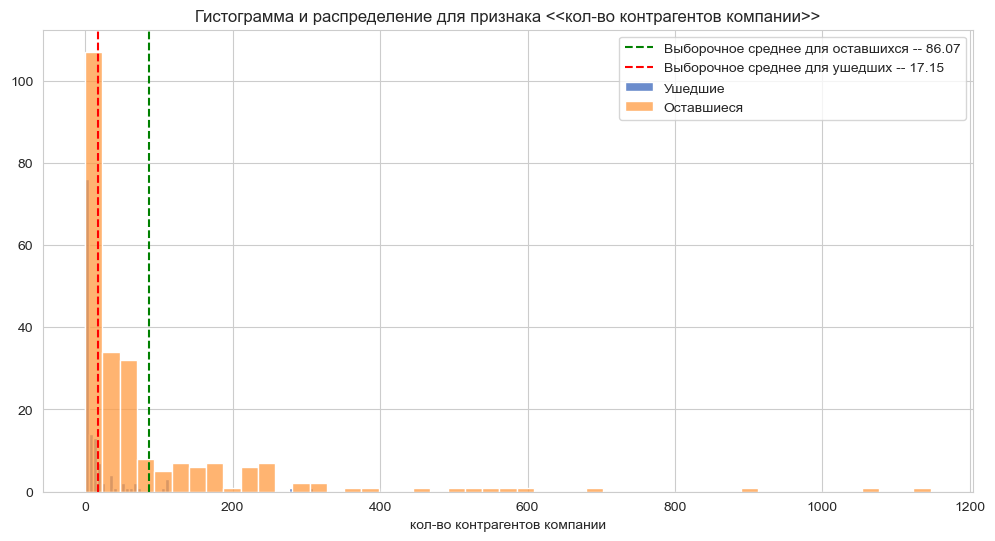

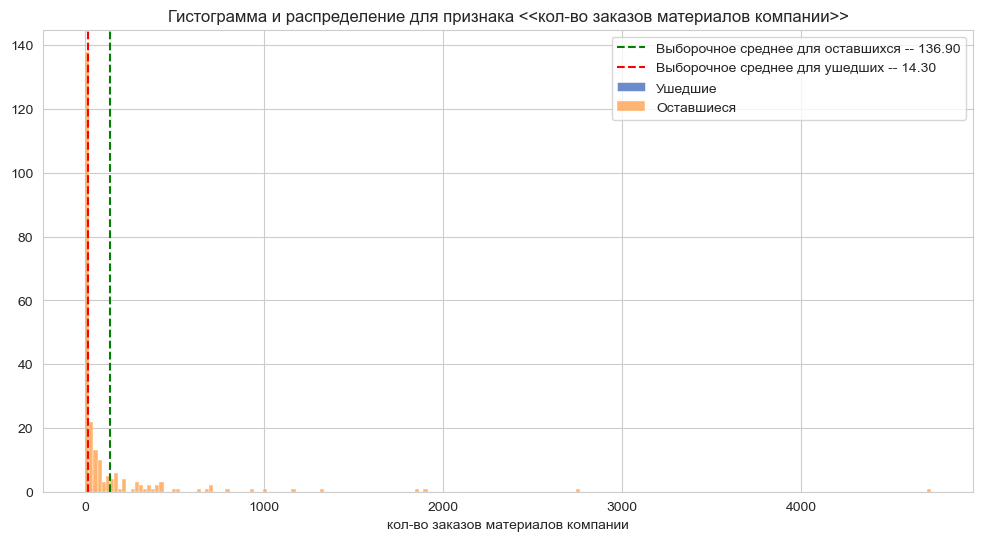

In [168]:
for col in intrvl_var:
    plt.figure(figsize=(12,6))
    sns.histplot(df_all[df_all.churn == 1][col], label = 'Ушедшие', color=colors1[0], kde = False)
    sns.histplot(df_all[df_all.churn == 0][col], label = 'Оставшиеся', color=colors1[1], kde = False)
    plt.axvline(df_all[df_all.churn == 0][col].mean(),
            color='green',linestyle='--', 
            label = 'Выборочное среднее для оставшихся -- {:.2f}'.\
            format(df_all[df_all.churn == 0][col].mean()));
    plt.axvline(df_all[df_all.churn == 1][col].mean(),
            color='red',linestyle='--', 
            label = 'Выборочное среднее для ушедших -- {:.2f}'.\
            format(df_all[df_all.churn == 1][col].mean()));
    plt.title("Гистограмма и распределение для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])
    plt.ylabel(None)
    plt.legend( )
    plt.show();

В целом графики подтверждают полученную ранее информацию, что действующие компании активнее пользуются приложением.

В таблице с информацией о компаниях есть солбец, отображающий данные: действует ли оплата. Посмотрим на его соответствие переменной оттока. Если компания действует, то оплата должна действовать тоже.


In [169]:
billing2324['company_id'].nunique()

1283

In [170]:
companies['company_id'].nunique()

723

Т.к. количество компаний  в таблицах не совпадает, то проверим по общим данным.

In [171]:
df= billing2324[['company_id', 'churn', 'tariff_cat', 'sub_m_cat']].merge(companies[['company_id', 'working_direction_cat', 'billing_is_over']], on = 'company_id')
df.duplicated().sum()

117

In [172]:
df = df.drop_duplicates()

In [173]:
df[df['billing_is_over']==True]['churn'].value_counts()

churn
1    243
0     41
Name: count, dtype: int64

In [174]:
df[df['billing_is_over']==False]['churn'].value_counts()

churn
0    366
1      9
Name: count, dtype: int64

Данные не совсем корректны, есть 41 компания где оплата истекла, но компания считается активной. И так же есть 9 компаний, считающихся ушедшими, хотя оплата у них действует. 

Мы считали компанию "не ушедшей" если на момент анализа подписка не истекла (последний срок по всем подпискам) и компания за все время сделала хоть один платеж. 
Данные по столбцу `billing_is_over` (истекла ли подписка) не совпадают с ранее полученными данными. Если подписка не истекла, то значение оттока `churn` должно равняться 0, т.е. фирма не ушла.
Это говорит о том, что данные собираются некорректно и значения в графах не соответствуют друг другу. 
Делать на это поправку в данном случае не имеет смысла, т.к. неизвестно, что считать правильным. Т.к. в целом логика совпала, то будем игнорировать значения этого столбца.

Посмотрим активность оплат и оттока по дате появления фирмы в компании Гектаро.

In [175]:
# месяц, определяющий когорту (первая дата появления в компании)
billing2324['cohort'] = billing2324.groupby('company_id')['created_at_M'].transform('min')
billing2324.insert(4,'cohort', billing2324.pop('cohort'))

In [176]:
# сколько договоров было оплачено, кол-во фирм, кол-во ушедших фирм
df = (
    billing2324
    .groupby('cohort')[['is_payed', 'company_id']]
    .agg(revenue= ('is_payed','sum'), cnt = ('company_id', 'nunique'))
    .reset_index())

In [177]:
df = df.merge((billing2324.groupby(['cohort','company_id'])['churn'].max().reset_index()).groupby('cohort')['churn'].sum().reset_index(), on = 'cohort')

In [178]:
df['%_no_churn'] = (df['cnt']-df['churn'])/df['cnt']*100
df = df.set_index('cohort')
df.columns = ['payed_cnt', 'cnt',	'churn_cnt', '%_no_churn']

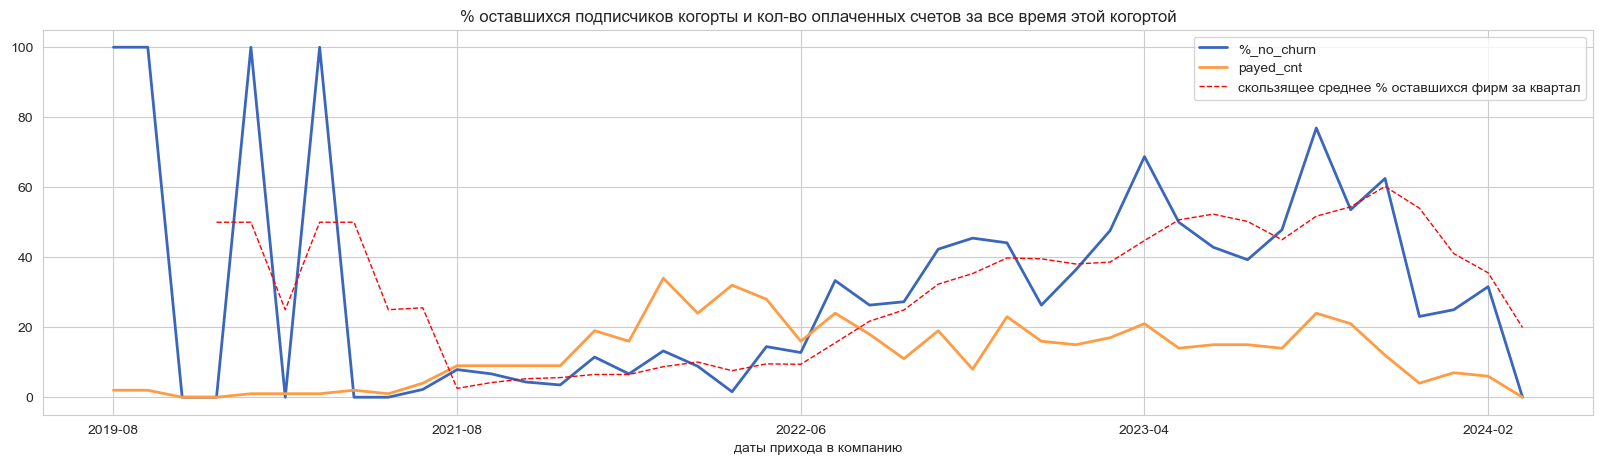

In [179]:
fig, ax = plt.subplots(figsize=(20,5))
df[['%_no_churn', 'payed_cnt']].plot( color=colors1, linewidth = 2, ax=ax)

plt.plot(df['%_no_churn'].reset_index()['cohort'],
         df['%_no_churn'].rolling(4).mean(), # rolling(интервал).mean()
         color='red',linestyle='--',
         linewidth=1,
         label='скользящее среднее % оставшихся фирм за квартал')


plt.title('% оставшихся подписчиков когорты и кол-во оплаченных счетов за все время этой когортой')
plt.ylabel(None)
plt.xlabel('даты прихода в компанию')
plt.legend();

In [180]:
df.sort_values(by = ['%_no_churn', 'cnt'], ascending=False)

,payed_cnt,cnt,churn_cnt,%_no_churn
cohort,,,,
2020-03,2,2,0,100.00
2019-08,2,1,0,100.00
2020-12,1,1,0,100.00
2021-04,1,1,0,100.00
2023-09,24,26,6,76.92
2023-04,21,16,5,68.75
2023-11,12,16,6,62.50
2023-10,21,28,13,53.57
2023-05,14,20,10,50.00


Посмотрим  когорты, когда пришло сразу много фирм (>10) и количество оставшихся клиентов было более 50%.

In [181]:
df[(df['cnt']>10)& (df['%_no_churn']>=50) ].sort_values(by = ['%_no_churn', 'cnt'], ascending=False)

,payed_cnt,cnt,churn_cnt,%_no_churn
cohort,,,,
2023-09,24,26,6,76.92
2023-04,21,16,5,68.75
2023-11,12,16,6,62.50
2023-10,21,28,13,53.57
2023-05,14,20,10,50.00


Посмотрим  когорты, когда пришло сразу много фирм (>10) но количество оставшихся клиентов было менее 30%.

In [182]:
df[(df['cnt']>10)& (df['%_no_churn']<30) ].sort_values(by = ['%_no_churn', 'cnt'])

,payed_cnt,cnt,churn_cnt,%_no_churn
cohort,,,,
2022-04,32,64,63,1.56
2021-07,4,45,44,2.22
2021-11,9,57,55,3.51
2021-10,9,69,66,4.35
2021-09,9,45,42,6.67
2022-01,16,90,84,6.67
2021-08,9,38,35,7.89
2022-03,24,79,72,8.86
2021-12,19,61,54,11.48


Можно выделить месяцы, когда пришедшие в программу фирмы не уходили в дальнейшем:
- сентябрь 2023 года: из 26 пришедших фирм в последствии ( на время анализа) ушли только 6. Этими фирмами были оплачены 24 счета.
- апрель 2023 года: из 16 пришедших фирм в последствии ( на время анализа) ушли только 5. Этими фирмами были оплачены 21 счет.
- можно выделить еще октябрь 2023 года, кгода пришло 28 фирм, в последствии ушло 13.

Так же выделяются провальные месяцы:
- апрель 2022 года. Пришло 64 фирмы, но ушло в последствии 63. 32 счета были оплачены.
- июль 2021 года. пришло 45 фирм и в последствии ушла 41 фирма.

Стоит отметить месяц, когда было привлечено больше всего фирм: февраль 2022 года - 121 фирма. Но в последствии 105 из них ушло. 

Отделу маркетинга следует оценить, какие акции провоились в указанные месяцы? Возможно реклама приводила не релевантных лидов. Или предлагались какие то скидки, которые в дальнейшем не подтверждались.

В данных отображено кол-во оплаченных счетов. НО т.к. не указана сумма оплаты, то делать на этом вывод нельзя. Возможно, там где число меньше счета были больше. Поэтому информация о ко-ве оплаченных счетов носит скорее вспомогательный характер. Делать вывод на его основе, что когорта была более успешная нельзя.

так же анализируя график " % оставшихся подписчиков когорты и кол-во оплаченных счетов за все время этой когортой" и числовые данные видно:
- есть месяцы, когда все пришедшие в программу остались в ней на время анализа. Но кол-во таких фирм мало (1или 2 в месяц) Всего есть 4 таких месяца. Следует посмотреть характеристики пришедших в этот период фирм, откуда они пришли и на каких условиях имеют подписку.
- в конце 2023 года увеличился % оттока. Кол-во осташихся в программе фирм резко пошло на спад. Что происходило в этот период в программе? Спад касается именно пришедших в это время.
  Возможно в программе были какие проблемы? не грузились нужные опции или еще что то, что повлияло на решение фирмы не работать в ней и уйти.

Посмотрим на активности на период 2023-2024 год. Добавим к данным характеристику оттока по id компании.

In [183]:
activ2324.company_id.nunique()

366

In [184]:
activ2324 = activ2324.merge(billing2324[['company_id','churn']], how = 'left', on =  'company_id')
activ2324.company_id.nunique()

366

In [185]:
activ2324.shape

(5028, 9)

In [186]:
activ2324.duplicated().sum()

2643

In [187]:
activ2324 = activ2324.drop_duplicates()
activ2324.shape

(2385, 9)

In [188]:
activ2324.insert(1,'churn', activ2324.pop('churn'))
activ2324 = activ2324.astype({'churn':'Int64'}, errors='ignore')
activ2324.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2385 entries, 0 to 5027
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   company_id                     2385 non-null   int64 
 1   churn                          2377 non-null   Int64 
 2   month                          2385 non-null   object
 3   company-month-billing          2385 non-null   int64 
 4   company-month-stocks           2385 non-null   int64 
 5   company-month-backups          2385 non-null   int64 
 6   company-month-projects         2385 non-null   int64 
 7   company-month-contractors      2385 non-null   int64 
 8   company-month-resource_orders  2385 non-null   int64 
dtypes: Int64(1), int64(7), object(1)
memory usage: 188.7+ KB


In [189]:
columns = ['company-month-billing','company-month-stocks', 'company-month-backups', 'company-month-projects', 'company-month-contractors','company-month-resource_orders']
activ2324_month = activ2324.groupby(['month', 'churn']).agg({**{e:'sum' for e in columns }})
activ2324_month = activ2324_month.reset_index().set_index('month')
activ2324_month.head()

,churn,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
month,,,,,,,
2023-01,0,23,774,211,667,799,1100
2023-01,1,13,336,130,378,267,232
2023-02,0,25,717,83,721,1163,1445
2023-02,1,12,423,45,444,233,282
2023-03,0,30,886,0,787,1416,1252


In [190]:
dict1_to_rus = {'churn':'churn',
'company-month-billing': 'кол-во счетов, выставленных в приложении суммарно в месяц у компаний',
'company-month-stocks': 'кол-во складов (аренда, заказы и т.д.), используемых суммарно в месяц  у компаний',
'company-month-backups': 'кол-во бэкапов суммарно в месяц у компаний',
'company-month-projects': 'кол-во проектов суммарно в месяц у компаний',
'company-month-contractors': 'кол-во контрагентов суммарно в месяц у компаний',
'company-month-resource_orders': 'кол-во заказов материалов суммарно в месяц у компаний'} 

In [191]:
df_m = activ2324_month.copy()
df_m.columns = df_m.columns.map(dict1_to_rus)
df_1 =df_m[df_m.churn ==1].drop('churn', axis= 1 )
df_0 =df_m[df_m.churn ==0].drop('churn', axis= 1 )  

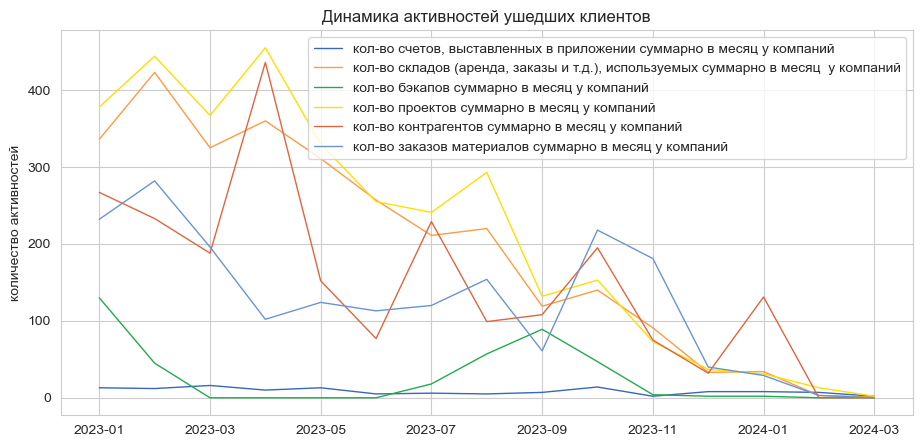

In [192]:
fig, ax = plt.subplots(figsize=(11,5))
df_1.plot(color=colors1, linewidth = 1, ax=ax)

plt.title('Динамика активностей ушедших клиентов')
plt.ylabel('количество активностей')
ax.legend()
plt.xlabel(None);


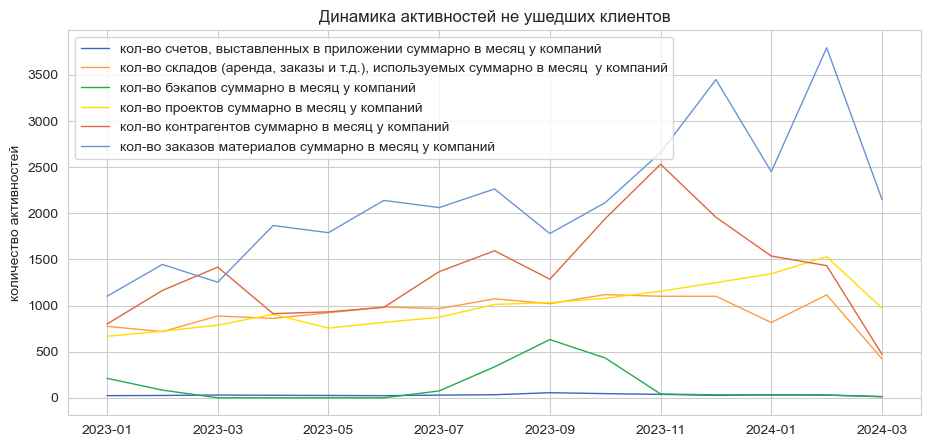

In [193]:
fig, ax = plt.subplots(figsize=(11,5))
df_0.plot(color=colors1, linewidth = 1, ax=ax)
plt.title('Динамика активностей не ушедших клиентов')
plt.ylabel('количество активностей')

plt.xlabel(None);

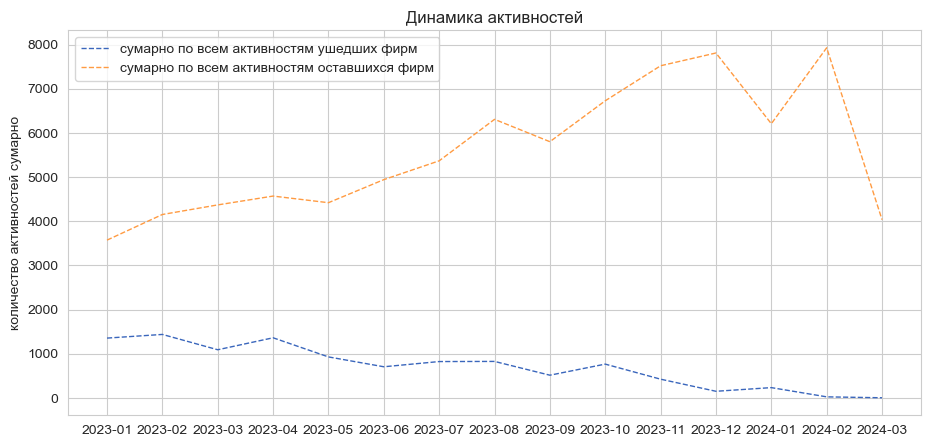

In [194]:
fig, ax = plt.subplots(figsize=(11,5))

plt.plot(activ2324_month[activ2324_month.churn ==1].reset_index()['month'],
         activ2324_month[activ2324_month.churn ==1][columns].sum(axis = 1), 
         color=colors1[0],linestyle='--',
         linewidth=1,
         label='cумарно по всем активностям ушедших фирм')

plt.plot(activ2324_month[activ2324_month.churn ==0].reset_index()['month'],
         activ2324_month[activ2324_month.churn ==0][columns].sum(axis = 1), 
         color=colors1[1],linestyle='--',
         linewidth=1,
         label='cумарно по всем активностям оставшихся фирм')

plt.title('Динамика активностей')
plt.ylabel('количество активностей сумарно')
plt.legend()
plt.xlabel(None);

В целом видно, что кол-во активностей у компаний, которые покинули программу сокращалось с течением времени. И на момент анализа активность ушедших фирм прекратилась.
Активность же оставшихся компаний со временем увеличивалась. Последний месяц анализа можно опустить, т.к. данные могли быть не полные.

Возникает предположение, что кол-во проектов, которые ведет компания влияет на ее активность. Чем больше проектов, тем больше активность. Проверим это. И если это так, то имеет смыл рассмотреть эту переменную более подробно.

In [195]:
columns1 = ['company-month-billing','company-month-stocks', 'company-month-backups',  'company-month-contractors',  'company-month-resource_orders']

In [196]:
df_projects_activ = activ2324.groupby('company_id').agg({**{e:'sum' for e in columns }}).sum(axis=1).reset_index().rename(columns = {0:'cnt_activ'}).merge(\
activ2324.groupby('company_id').agg(projects_cnt = ('company-month-projects', 'max')).reset_index(), on = 'company_id')        

In [197]:
df_projects_activ.set_index('company_id').corr()

,cnt_activ,projects_cnt
cnt_activ,1.00,0.75
projects_cnt,0.75,1.00


Значение корреляции 75%, что говорит о возможной сильной прямой связи. Тут выбиральсь максимальное кол-во проектов у компании за все время работы. Посмотрим на кореляцию суммарного значения проектов у компании.

In [198]:
activ2324.groupby('company_id').agg({**{e:'sum' for e in columns }}).sum(axis=1).reset_index().rename(columns = {0:'cnt_activ'}).merge(\
activ2324.groupby('company_id').agg(projects_cnt = ('company-month-projects', 'sum')).reset_index(), on = 'company_id').set_index('company_id').corr()

,cnt_activ,projects_cnt
cnt_activ,1.00,0.79
projects_cnt,0.79,1.00


Корреляция еще больше, почти 80%.


Колоичество проектов, которое ведет компания. 
Ранее мы пришли к выводу, что компании, которые ушли, сократили активность в программе. Возможно, если у компании уменьшается кол-во проектов, то она прекращает активность и в дальнейшем уходит?


Рассмотрим кол-во проектов у компании в течении работы в программе. Значения каждый месяц могут быть разные. Хочется понять, уменьшается ли кол-во проектов у компании с течением времени, остается без измененй или увеличивается? Как оценить эту тенденцию за все время работы компании? Как это влияет на отток компаний?

От этого показателя будет зависить активность компании, т.к. если проектов много, то компании активнее пользуются нашим продуктом (кол-во активностей возрастает).
Возникает и предположение, что если компания сокращает число проектов, то она может уйти.

Число проектов не зависит от тарифа. Тариф влияет на кол-во пользователей и некоторые другие опции программы.

Для каждой компании вычислим 3 коэффициента:
1. Возросло ли кол-во проектов с первого месяца активности до последнего? Т.е. Если в первом месяце работы у компании был 1 проект, а в последнем 2 или больше, то коэффициент будем считать положительным. Если кол-во не поменялось  - 0, иначе отрицательный.
2. Общая тенденция за все время работы компании. Будем оценивать ее по всем значениям. Расчитывать будем , как разницу между следующим и предыдущем значением и общую сумму полученных значений.
3. Прирост активности за последние 2 месяца.
   
В случае явного ухудшения ситуации значение будет отрицательное. У улучшения - положительное.
   
Оценим отток компании по этим коэффициентам.

In [199]:
# 1 коэффициент. Разница между последним и первым значением.
df_ratio1 = ((activ2324.sort_values(by = ['company_id', 'month'])
     .groupby('company_id')[['company_id','company-month-projects']]
     .transform('first').rename(columns = {'company-month-projects':'projects_first'}) ). \
 merge (
    (activ2324.sort_values(by = ['company_id', 'month'])
     .groupby('company_id')[['company_id','company-month-projects']]
     .transform('last').rename(columns = {'company-month-projects':'projects_last'})) ,
    on = 'company_id')).drop_duplicates()
df_ratio1['ratio1'] = df_ratio1['projects_last']-df_ratio1['projects_first']
df_ratio1 = df_ratio1[['company_id', 'ratio1']]
df_ratio1 

,company_id,ratio1
0,21,-3
25,336,2
29,383,-3
33,408,-1
154,495,0
...,...,...
22239,9777,0
22243,9802,23
22247,9815,9
22256,9817,4


In [200]:
# 2 и 3 коэффициенты
df_ratio2 = pd.DataFrame( [[-1,0,0,0]], columns=['company_id','churn','ratio2','ratio3'])
company_id = list(activ2324['company_id'].unique())

for id in company_id:

    df = activ2324[activ2324['company_id']==id][['company_id','churn','month', 'company-month-projects'  ]].sort_values(by = ['company_id', 'month'])
    df['month-projects_last'] = df['company-month-projects'].shift(1, fill_value=0)    
    df['walk'] = df['company-month-projects']- df['month-projects_last']   
    df['ratio2'] = df['walk'].sum()
    df['ratio3'] = df['walk'][ -2:].sum()
    df = df[['company_id', 'churn', 'ratio2','ratio3']]
    df = df.drop_duplicates()
    df_ratio2 = pd.concat([df_ratio2, df], ignore_index=True)


In [201]:
df_ratio2 = df_ratio2[df_ratio2['company_id'] !=-1]

In [202]:
df = df_ratio2.merge(df_ratio1, on = 'company_id')

In [203]:
columns = ['ratio1', 'ratio2', 'ratio3']
dict_to_rus = {'ratio1': 'разница между  кол-вом проектов в последний и первый месяц работы  в программе', 'ratio2': 'прирост активности за весь период', \
'ratio3': 'прирост активности за последние 2 месяца'}

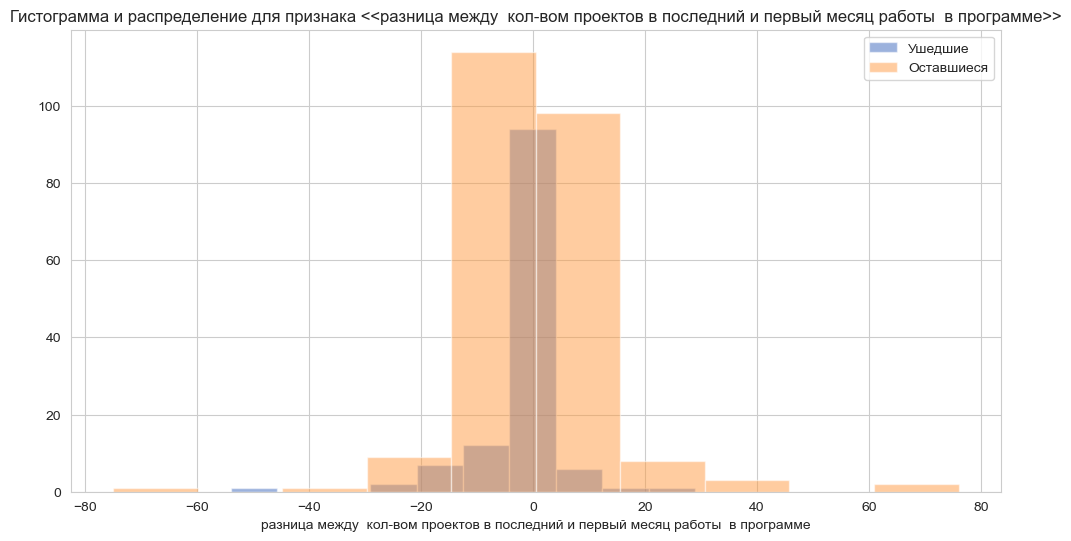

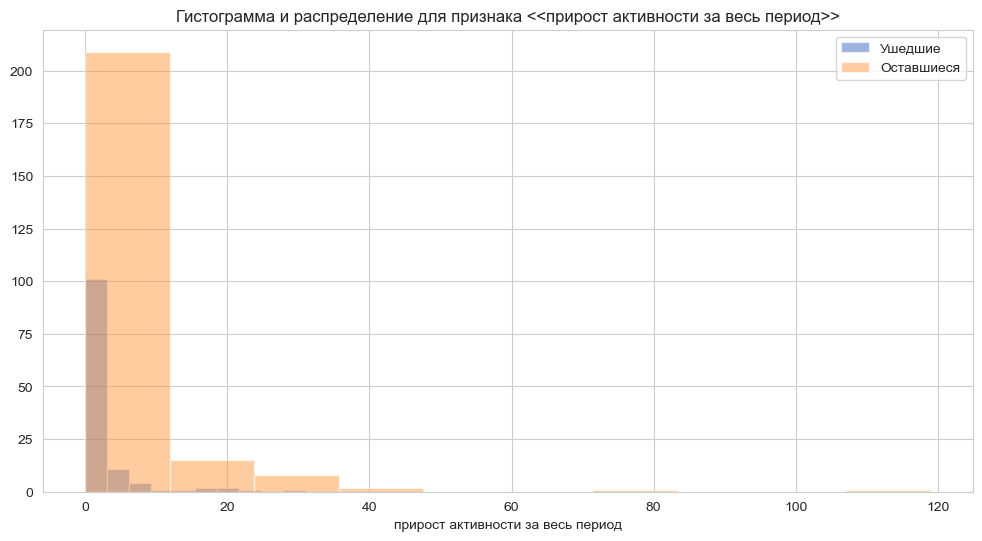

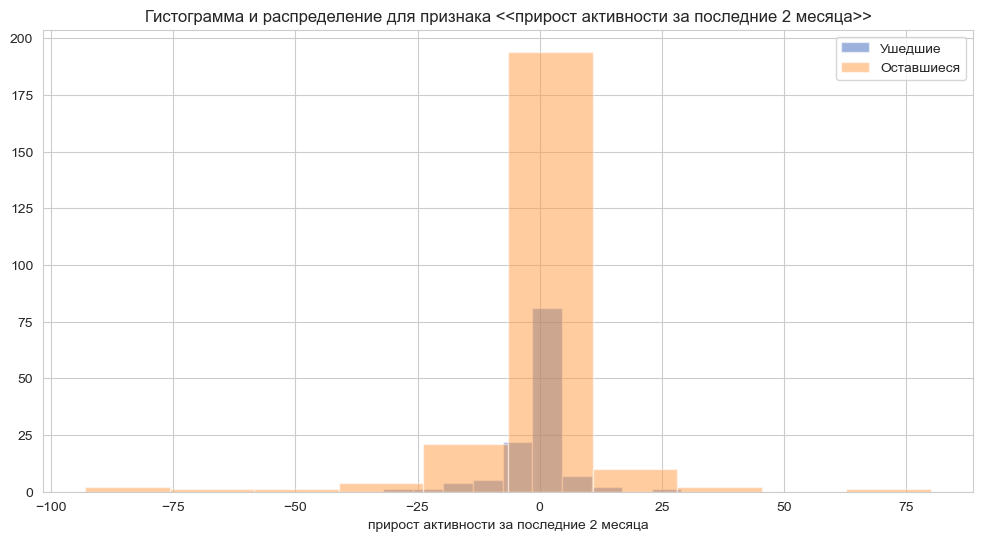

In [204]:
for col in columns:
    plt.figure(figsize=(12,6))
    plt.hist(df[df.churn == 1][col], label = 'Ушедшие', color=colors1[0], alpha=0.5)
    plt.hist(df[df.churn == 0][col], label = 'Оставшиеся', color=colors1[1], alpha=0.5)
    
    plt.title("Гистограмма и распределение для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])
    plt.ylabel(None)
    plt.legend( )
    plt.show();

Т.к. активностей в целом больше у оставшихся компаний (известно из предыдущенго анализа) это хорошо видно и на графиках. 
Есть предположение, что если активность в последние 2 месяца падает, то компания будет склонна к оттоку в дальнейшем. Посмотрим данные в % 

In [205]:
# ушедшие с отрицательным приростом активности за последние 2 месяца работы в программе
df[(df['churn']==1) &(df['ratio3']<0)].shape[0]/df[df['churn']==1].shape[0]*100

35.483870967741936

In [206]:
# ушедшие с положительным или постоянным приростом активности за последние 2 месяца работы в программе
df[(df['churn']==1) &(df['ratio3']>=0)].shape[0]/df[df['churn']==1].shape[0]*100

64.51612903225806

In [207]:
# оставшиеся с отрицательным приростом активности за последние 2 месяца работы в программе
df[(df['churn']==0) &(df['ratio3']<0)].shape[0]/df[df['churn']==0].shape[0]*100

34.32203389830508

In [208]:
# оставшиеся с положительным или постоянным приростом активности за последние 2 месяца работы в программе
df[(df['churn']==0) &(df['ratio3']>=0)].shape[0]/df[df['churn']==0].shape[0]*100

65.67796610169492

Разница между ушедшими и оставшимися не велика. Возможно это обусловленно тем, что мы оцениваем именно активность. Но в целом у тех, кто ушел активности в программе намного меньше. Данные не выгружены за все месяцы, а только за те, где эта активность была. Поэтому возможно искажение результатов анализа.

# Общий вывод :

- возможно данные собраны или выгружены не корректно. Есть разногласия в значениях. Нарушена логика действий компаний.
- выделена целевая переменная - отток фирмы.
- можно утверждать, что компании, которые остались активны и не ушли, пользуются программой больше тех, кто ушел. По всем видам деятельности в таблице активности у компаний, которые остались действий больше
- Значение должности <1> присутствует у всех компаниях. Возможно это лицо принимающее решение.
- Есть компании, которые заключают договор, оплачивают его, но не делают никаких активных действий ( не пользуются программой). Тарифы при этом могут изменится и быть оплачены.
- Есть компании, которые многократно меняли тариф, но не ведут при этом никакой активной деятельности. Это и предыдущее наблюдение так же говорит о возможных ошибках в сборе данных. Иначе логике действия компаний не поддаются.- Тариф  у компании мог меняться с дорогого на дешевый, и наоборот, но повлияло ли это на выручку сказать нельзя. Нет данных о фактически уплоченных деньгах. Может быть фирма получила более дорогой тариф со скидкой и когда поменяла его на более дешевый денег заплатила столько же. Возможно и обратная ситуация. Сделать однозначный вывод сколько при этом получилось прибыли у Гектаро - нельзя.
- В большинстве случаев фирма тариф не меняла.
- Наиболее часто встречается подписка на 12, 18 и 24 месяца. Но так же встречаются и другие значения. На сайте компании Гектаро нет информации о том, что подписку можно оплачивать помесячно. Там указаны цены за месяц при годовой подписке. Возможно клиентам делались предложения личного характера, предоставлялись специальные условия. В данных это никак не отражено.
- Наибольшим спросом пользуются тарифы базовый и стартовый. В начале 2023 года было заявлено много подписок, которые не оплачивали. Возможно была рекламная компания, которая привлекла много новых клиентов, которые решили не использовать сервис.
- Складывается ощущение, что в данных не отражена пробная версия подписки (бесплатно 7 дней). Если это так, то понятно, почему компании с не оплаченными подпискам имеют активности.
- Сфера деятельности компании заполнена у небольшого кол-ва компаний. И ее заполнение велось в ручную, т.к. данные имеют множество смысловых дубликатов и множество различных значений. поэтому сделать вывод, какая сфера деятельности склонна к оттоку сложно. Из тех данных, что есть выделяется только сфера строительства (67 фирм остались и 	45 фирм ушли) Но тк много фирм не указали свою сферу деятельности, то делать однозначных выводов нельзя.
- Выделены месяцы, в которых пришедшие фирмы показывали разный % оттока. Максимальные и минимальные значения:

            
            - сентябрь 2023 года: из 26 пришедших фирм в последствии ( на время анализа) ушли только 6. Этими фирмами были оплачены 24 счета.
            - апрель 2023 года: из 16 пришедших фирм в последствии ( на время анализа) ушли только 5. Этими фирмами были оплачены 21 счет.
            - можно выделить еще октябрь 2023 года, кгода пришло 28 фирм, в последствии ушло 13.
            
            Так же выделяются провальные месяцы:
            - апрель 2022 года. Пришло 64 фирмы, но ушло в последствии 63. 32 счета были оплачены.
            - июль 2021 года. пришло 45 фирм и в последствии ушла 41 фирма.
            
            Стоит отметить месяц, когда было привлечено больше всего фирм: февраль 2022 года - 121 фирма. Но в последствии 105 из них ушло. 
            
            Отделу маркетинга следует оценить, какие акции провоились в указанные месяцы? Возможно реклама приводила не релевантных лидов. Или предлагались какие то скидки, которые в дальнейшем не подтверждались.
            
             - есть месяцы, когда все пришедшие в программу остались в ней на время анализа. Но кол-во таких фирм мало (1или 2 в месяц) Всего есть 4 таких месяца. Следует посмотреть характеристики пришедших в этот период фирм, откуда они пришли и на каких условиях имеют подписку?

- в конце 2023 года увеличился % оттока. Кол-во осташихся в программе фирм резко пошло на спад. Что происходило в этот период в программе? Спад касается именно пришедших в это время.
 Возможно в программе были какие проблемы? не грузились нужные опции или еще что то, что повлияло на решение фирмы не работать в ней и уйти.



## Пожелания и рекомендации заказчику:

1. 
    Что бы  составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, требуется получить более согласованные данные. 
    Необходимо получить по каждой компании ее характеристики, которые можно анализировать предметно. 
    При сборе такой информации требуется заполнение полей по образцу: 
    - сфера деятельности компании, 
    - характеристики фирмы (кол-во сотрудников принимающих решение и другие)
    - **действие оплаченной подписки на сегодняшний день (да/нет).** 
    - Кол-во месяцев оплаченной подписки.
    - Была ли продлена подписка хотя бы 1 раз?  (это особенно важно, если подписку продают на большой период времени сразу)
    - действует ли бесплатный период (да/нет) на сегодняшний день.
    - дейстельность фирмы по месяцам (тут можно оставить данные в таблице активности, но проверить, что выгрузка прошла правильно)
    
    **Уникальное кол-во компаний должно совпадать во всех таблицах. Это соответствет тому, что про все зарегистрированные в программе фирмы данные собираются**
    
    При наличии такой информации можно выделить кластеры на основе собранных данных и проанализировать их на склонность к оттоку, выделяя имеющиеся характеристики.

2. Фирмы, которые остаются в программе, ведут активную деятельность. Следует оценивать эту характеристику. Если фирма сокращает активность, то возможно она прекратит сотрудничество в дальнейшем.
   Следует работать с такими фирмами внимательнее. Возможно им следует предложить заморозку в программе или дполнительные опции.

3. Так же вероятнось оттока больше у тех фирм, где небольшое кол-во проектов и это кол-во снижется со временем.
4. За пару месяцев до окончания текущего договора  или после 2-х месяцев прекращения активности в программе отделу по работе с клиентами следует поинтересоваться у компании, собирается ли она продолжать сотрудничество и что можно улучшить в работе сервиса. Это позволит вовремя отреогировать на изменяющиеся  потребности клиентов.

